# Commodity Food Pricing: Data Analysis
**By:** `MSOE AI-Club "Nourish" Student Research Team`<br/>
**Primary Notebook Developers:** Ben Paulson, Sydney Balboni

**Notebook Purpose:** to analyze the relationships between the changing prices of international food commodities over time compared to other, potentially significant, economic inidicators. By downloading associated datasets, cleaning them to provide more significant signal, and then analyzing them, we can gain insight into determining how economic indiciators -- along with previous food-price trend data -- can be used to predict future food prices. The outcome of this analysis will be encoded data-input to a model which can accurately perform this prediction, hosted in a separate notebook. [FAO Official Statement on the Importance of Research Like This](https://youtu.be/sZx3hhnEHiI). There is also significant documentation with each section for both code/purpose sanity, sake of future reproducibility, and to help other members of the `MSOE AI-Club "Nourish" Student Research Team` understand the code and its purpose.
* **Part 1: Retrieving Data**
* **Part 2: EDA & Statistical Analysis**

**Research Context:** This research is being conducted as part of the MSOE AI-Club's "Nourish" project, which aims to use machine learning to predict future food prices in order to help farmers in developing countries make better decisions about food storage and crop selection, achieved through the accurate warning administration and prediction of food commodity pricing data by country and food market. This project is pending as part of a relationship with the United Nation's Food and Agriculture Organization (FAO).

In [67]:
!pip install PyPDF2

     ---------------------------------------- 0.0/232.6 kB ? eta -:--:--
     - -------------------------------------- 10.2/232.6 kB ? eta -:--:--
     ---- -------------------------------- 30.7/232.6 kB 435.7 kB/s eta 0:00:01
     ------------------- ---------------- 122.9/232.6 kB 901.1 kB/s eta 0:00:01
     -------------------------------------- 232.6/232.6 kB 1.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [150]:
# Webscraper applications (Selenium 4)
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys

# Data manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PyPDF2

# Machine Learning
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.stats import spearmanr

# Internal Python Imports
import time
import os
import re

## Part 1: Retrieving Data
The data used throughout this research is as follows:
* **PROTEUS Index:** An encoded food-security indicator developed by the UN FAO. Ranges from 0 to 1; the closer the value to zero, the greater the food security. Also, this value "proves flexible enough to capture sudden onset crises and to reflect the main drivers that can dramatically affect a country's food security in the short run" (FAO).
    * [PROTEUS Index Data](https://analytics.wfp.org/t/Public/views/Proteus_index_2017_NC/PROTEUSIndicatorstree?%3Adisplay_count=n&%3Aembed=y&%3AisGuestRedirectFromVizportal=y&%3Aorigin=viz_share_link&%3AshowAppBanner=false&%3AshowVizHome=n)
    * [Data & Data-Explanation Found Here](https://dataviz.vam.wfp.org/version2/reports/global-coverage-proteus-food-security-index-oct-2019)
    * [Original Research Paper](https://www.sciencedirect.com/science/article/abs/pii/S0305750X19303572)
* **Food Indices:** The FAO has developed a number of indices which measure the overall price globally for varying commodity categories, including a general "food" index. These indices are as follows: Food, meat, cereal, sugar, oils, and dairy. These indices are important because they provide a general overview of the global food market, which can be used to determine the overall trend of the market.
    * [Food Indices Data](http://www.fao.org/worldfoodsituation/foodpricesindex/en/)
* **Current Food Commodity Prices:** The current value of different food commodities divided by country which is selling those food commodities. Choosing between food commodity pricing at the international, wholesale, or retail price point boils down to both the purpose and accuracy of this research. Respectively, this research aims to provide a model which can accurately predict the future price of food commodities for country food security, and more data (including futures data) is available at the international level. Therefore, the international price of food commodities is used as opposed to the other options.
    * **International Prices:** https://fpma.fao.org/giews/fpmat4/#/dashboard/tool/international
    * **Domestic Prices (Wholesale & Retail):** https://fpma.fao.org/giews/fpmat4/#/dashboard/tool/domestic
* **Futures Trend Data:** Futures are call options where traders estimate how the price will fluctuate in the future. The benefit to traders is that if they purchase a futures contract where the monetary value is less than the actual value at that time, the trader will purchase that commodity at a discount; however, the trader can cancel their contract if that actual value is lower than the contracted futures value. The benefit to the sellers is they will at least get the guaranteed premium income if the value of the commodity depreciates. Futures are important because they are currently the best indicator for how the traders believe the future of the market will perform in the short/medium term.
    * [Yahoo Finance Futures Data](https://finance.yahoo.com/commodities/)
        * [International (ICE) Sugar Futures](https://finance.yahoo.com/chart/SB%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJ3ZWVrIiwicGVyaW9kaWNpdHkiOjEsInRpbWVVbml0IjpudWxsLCJjYW5kbGVXaWR0aCI6MSwiZmxpcHBlZCI6ZmFsc2UsInZvbHVtZVVuZGVybGF5Ijp0cnVlLCJhZGoiOnRydWUsImNyb3NzaGFpciI6dHJ1ZSwiY2hhcnRUeXBlIjoibW91bnRhaW4iLCJleHRlbmRlZCI6ZmFsc2UsIm1hcmtldFNlc3Npb25zIjp7fSwiYWdncmVnYXRpb25UeXBlIjoib2hsYyIsImNoYXJ0U2NhbGUiOiJsaW5lYXIiLCJzdHVkaWVzIjp7IuKAjHZvbCB1bmRy4oCMIjp7InR5cGUiOiJ2b2wgdW5kciIsImlucHV0cyI6eyJTZXJpZXMiOiJzZXJpZXMiLCJpZCI6IuKAjHZvbCB1bmRy4oCMIiwiZGlzcGxheSI6IuKAjHZvbCB1bmRy4oCMIn0sIm91dHB1dHMiOnsiVXAgVm9sdW1lIjoiIzBkYmQ2ZWVlIiwiRG93biBWb2x1bWUiOiIjZmY1NTQ3ZWUifSwicGFuZWwiOiJjaGFydCIsInBhcmFtZXRlcnMiOnsiY2hhcnROYW1lIjoiY2hhcnQiLCJlZGl0TW9kZSI6dHJ1ZX0sImRpc2FibGVkIjpmYWxzZX19LCJwYW5lbHMiOnsiY2hhcnQiOnsicGVyY2VudCI6MSwiZGlzcGxheSI6IlNCPUYiLCJjaGFydE5hbWUiOiJjaGFydCIsImluZGV4IjowLCJ5QXhpcyI6eyJuYW1lIjoiY2hhcnQiLCJwb3NpdGlvbiI6bnVsbH0sInlheGlzTEhTIjpbXSwieWF4aXNSSFMiOlsiY2hhcnQiLCLigIx2b2wgdW5kcuKAjCJdfX0sInNldFNwYW4iOnsiYmFzZSI6ImFsbCIsIm11bHRpcGxpZXIiOjF9LCJvdXRsaWVycyI6ZmFsc2UsImFuaW1hdGlvbiI6dHJ1ZSwiaGVhZHNVcCI6eyJzdGF0aWMiOnRydWUsImR5bmFtaWMiOmZhbHNlLCJmbG9hdGluZyI6ZmFsc2V9LCJsaW5lV2lkdGgiOjIsImZ1bGxTY3JlZW4iOnRydWUsInN0cmlwZWRCYWNrZ3JvdW5kIjp0cnVlLCJjb2xvciI6IiMwMDgxZjIiLCJzeW1ib2xzIjpbeyJzeW1ib2wiOiJTQj1GIiwic3ltYm9sT2JqZWN0Ijp7InN5bWJvbCI6IlNCPUYiLCJxdW90ZVR5cGUiOiJGVVRVUkUiLCJleGNoYW5nZVRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIm1hcmtldCI6InVzMjRfbWFya2V0In0sInBlcmlvZGljaXR5IjoxLCJpbnRlcnZhbCI6IndlZWsiLCJ0aW1lVW5pdCI6bnVsbCwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX19XX0sImV2ZW50cyI6eyJkaXZzIjp0cnVlLCJzcGxpdHMiOnRydWUsInRyYWRpbmdIb3Jpem9uIjoibm9uZSIsInNpZ0RldkV2ZW50cyI6W119LCJwcmVmZXJlbmNlcyI6e319)
        * [International (CBOT) Corn Futures](https://finance.yahoo.com/chart/ZC%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJtb250aCIsInBlcmlvZGljaXR5IjoxLCJ0aW1lVW5pdCI6bnVsbCwiY2FuZGxlV2lkdGgiOjQuMDkyMTk4NTgxNTYwMjgzLCJmbGlwcGVkIjpmYWxzZSwidm9sdW1lVW5kZXJsYXkiOnRydWUsImFkaiI6dHJ1ZSwiY3Jvc3NoYWlyIjp0cnVlLCJjaGFydFR5cGUiOiJtb3VudGFpbiIsImV4dGVuZGVkIjpmYWxzZSwibWFya2V0U2Vzc2lvbnMiOnt9LCJhZ2dyZWdhdGlvblR5cGUiOiJvaGxjIiwiY2hhcnRTY2FsZSI6ImxpbmVhciIsInBhbmVscyI6eyJjaGFydCI6eyJwZXJjZW50IjoxLCJkaXNwbGF5IjoiWkM9RiIsImNoYXJ0TmFtZSI6ImNoYXJ0IiwiaW5kZXgiOjAsInlBeGlzIjp7Im5hbWUiOiJjaGFydCIsInBvc2l0aW9uIjpudWxsfSwieWF4aXNMSFMiOltdLCJ5YXhpc1JIUyI6WyJjaGFydCIsIuKAjHZvbCB1bmRy4oCMIl19fSwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX0sIm91dGxpZXJzIjpmYWxzZSwiYW5pbWF0aW9uIjp0cnVlLCJoZWFkc1VwIjp7InN0YXRpYyI6dHJ1ZSwiZHluYW1pYyI6ZmFsc2UsImZsb2F0aW5nIjpmYWxzZX0sImxpbmVXaWR0aCI6MiwiZnVsbFNjcmVlbiI6dHJ1ZSwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN5bWJvbHMiOlt7InN5bWJvbCI6IlpDPUYiLCJzeW1ib2xPYmplY3QiOnsic3ltYm9sIjoiWkM9RiIsInF1b3RlVHlwZSI6IkZVVFVSRSIsImV4Y2hhbmdlVGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwibWFya2V0IjoidXMyNF9tYXJrZXQifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoibW9udGgiLCJ0aW1lVW5pdCI6bnVsbCwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX19XSwic3R1ZGllcyI6eyLigIx2b2wgdW5kcuKAjCI6eyJ0eXBlIjoidm9sIHVuZHIiLCJpbnB1dHMiOnsiU2VyaWVzIjoic2VyaWVzIiwiaWQiOiLigIx2b2wgdW5kcuKAjCIsImRpc3BsYXkiOiLigIx2b2wgdW5kcuKAjCJ9LCJvdXRwdXRzIjp7IlVwIFZvbHVtZSI6IiMwZGJkNmVlZSIsIkRvd24gVm9sdW1lIjoiI2ZmNTU0N2VlIn0sInBhbmVsIjoiY2hhcnQiLCJwYXJhbWV0ZXJzIjp7ImNoYXJ0TmFtZSI6ImNoYXJ0IiwiZWRpdE1vZGUiOnRydWUsInBhbmVsTmFtZSI6ImNoYXJ0In0sImRpc2FibGVkIjpmYWxzZX19fSwiZXZlbnRzIjp7ImRpdnMiOnRydWUsInNwbGl0cyI6dHJ1ZSwidHJhZGluZ0hvcml6b24iOiJub25lIiwic2lnRGV2RXZlbnRzIjpbXX0sInByZWZlcmVuY2VzIjp7ImN1cnJlbnRQcmljZUxpbmUiOnRydWUsImRpc3BsYXlDcm9zc2hhaXJzV2l0aERyYXdpbmdUb29sIjpmYWxzZSwiZHJhZ2dpbmciOnsic2VyaWVzIjp0cnVlLCJzdHVkeSI6dHJ1ZSwieWF4aXMiOnRydWV9LCJkcmF3aW5ncyI6bnVsbCwiaGlnaGxpZ2h0c1JhZGl1cyI6MTAsImhpZ2hsaWdodHNUYXBSYWRpdXMiOjMwLCJtYWduZXQiOmZhbHNlLCJob3Jpem9udGFsQ3Jvc3NoYWlyRmllbGQiOm51bGwsImxhYmVscyI6dHJ1ZSwibGFuZ3VhZ2UiOm51bGwsInRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIndoaXRlc3BhY2UiOjUwLCJ6b29tSW5TcGVlZCI6bnVsbCwiem9vbU91dFNwZWVkIjpudWxsLCJ6b29tQXRDdXJyZW50TW91c2VQb3NpdGlvbiI6ZmFsc2V9fQ--)
        * [International (CBOT) Oat Futures](https://finance.yahoo.com/chart/ZO%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJ3ZWVrIiwicGVyaW9kaWNpdHkiOjEsInRpbWVVbml0IjpudWxsLCJjYW5kbGVXaWR0aCI6MSwiZmxpcHBlZCI6ZmFsc2UsInZvbHVtZVVuZGVybGF5Ijp0cnVlLCJhZGoiOnRydWUsImNyb3NzaGFpciI6dHJ1ZSwiY2hhcnRUeXBlIjoibW91bnRhaW4iLCJleHRlbmRlZCI6ZmFsc2UsIm1hcmtldFNlc3Npb25zIjp7fSwiYWdncmVnYXRpb25UeXBlIjoib2hsYyIsImNoYXJ0U2NhbGUiOiJsaW5lYXIiLCJwYW5lbHMiOnsiY2hhcnQiOnsicGVyY2VudCI6MSwiZGlzcGxheSI6IlpPPUYiLCJjaGFydE5hbWUiOiJjaGFydCIsImluZGV4IjowLCJ5QXhpcyI6eyJuYW1lIjoiY2hhcnQiLCJwb3NpdGlvbiI6bnVsbH0sInlheGlzTEhTIjpbXSwieWF4aXNSSFMiOlsiY2hhcnQiLCLigIx2b2wgdW5kcuKAjCJdfX0sInNldFNwYW4iOnsiYmFzZSI6ImFsbCIsIm11bHRpcGxpZXIiOjF9LCJvdXRsaWVycyI6ZmFsc2UsImFuaW1hdGlvbiI6dHJ1ZSwiaGVhZHNVcCI6eyJzdGF0aWMiOnRydWUsImR5bmFtaWMiOmZhbHNlLCJmbG9hdGluZyI6ZmFsc2V9LCJsaW5lV2lkdGgiOjIsImZ1bGxTY3JlZW4iOnRydWUsInN0cmlwZWRCYWNrZ3JvdW5kIjp0cnVlLCJjb2xvciI6IiMwMDgxZjIiLCJzeW1ib2xzIjpbeyJzeW1ib2wiOiJaTz1GIiwic3ltYm9sT2JqZWN0Ijp7InN5bWJvbCI6IlpPPUYiLCJxdW90ZVR5cGUiOiJGVVRVUkUiLCJleGNoYW5nZVRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIm1hcmtldCI6InVzMjRfbWFya2V0In0sInBlcmlvZGljaXR5IjoxLCJpbnRlcnZhbCI6IndlZWsiLCJ0aW1lVW5pdCI6bnVsbCwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX19XSwic3R1ZGllcyI6eyLigIx2b2wgdW5kcuKAjCI6eyJ0eXBlIjoidm9sIHVuZHIiLCJpbnB1dHMiOnsiU2VyaWVzIjoic2VyaWVzIiwiaWQiOiLigIx2b2wgdW5kcuKAjCIsImRpc3BsYXkiOiLigIx2b2wgdW5kcuKAjCJ9LCJvdXRwdXRzIjp7IlVwIFZvbHVtZSI6IiMwZGJkNmVlZSIsIkRvd24gVm9sdW1lIjoiI2ZmNTU0N2VlIn0sInBhbmVsIjoiY2hhcnQiLCJwYXJhbWV0ZXJzIjp7ImNoYXJ0TmFtZSI6ImNoYXJ0IiwiZWRpdE1vZGUiOnRydWUsInBhbmVsTmFtZSI6ImNoYXJ0In0sImRpc2FibGVkIjpmYWxzZX19fSwiZXZlbnRzIjp7ImRpdnMiOnRydWUsInNwbGl0cyI6dHJ1ZSwidHJhZGluZ0hvcml6b24iOiJub25lIiwic2lnRGV2RXZlbnRzIjpbXX0sInByZWZlcmVuY2VzIjp7ImN1cnJlbnRQcmljZUxpbmUiOnRydWUsImRpc3BsYXlDcm9zc2hhaXJzV2l0aERyYXdpbmdUb29sIjpmYWxzZSwiZHJhZ2dpbmciOnsic2VyaWVzIjp0cnVlLCJzdHVkeSI6dHJ1ZSwieWF4aXMiOnRydWV9LCJkcmF3aW5ncyI6bnVsbCwiaGlnaGxpZ2h0c1JhZGl1cyI6MTAsImhpZ2hsaWdodHNUYXBSYWRpdXMiOjMwLCJtYWduZXQiOmZhbHNlLCJob3Jpem9udGFsQ3Jvc3NoYWlyRmllbGQiOm51bGwsImxhYmVscyI6dHJ1ZSwibGFuZ3VhZ2UiOm51bGwsInRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIndoaXRlc3BhY2UiOjUwLCJ6b29tSW5TcGVlZCI6bnVsbCwiem9vbU91dFNwZWVkIjpudWxsLCJ6b29tQXRDdXJyZW50TW91c2VQb3NpdGlvbiI6ZmFsc2V9fQ--)
        * [International (CBOT) Wheat Futures](https://finance.yahoo.com/chart/KE%3DF)
        * [International (CBOT) Rough Rice Futures](https://finance.yahoo.com/chart/ZR%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJtb250aCIsInBlcmlvZGljaXR5IjoxLCJ0aW1lVW5pdCI6bnVsbCwiY2FuZGxlV2lkdGgiOjMuOTY4OTc1OTY3ODMxMDgyLCJmbGlwcGVkIjpmYWxzZSwidm9sdW1lVW5kZXJsYXkiOnRydWUsImFkaiI6dHJ1ZSwiY3Jvc3NoYWlyIjp0cnVlLCJjaGFydFR5cGUiOiJtb3VudGFpbiIsImV4dGVuZGVkIjpmYWxzZSwibWFya2V0U2Vzc2lvbnMiOnt9LCJhZ2dyZWdhdGlvblR5cGUiOiJvaGxjIiwiY2hhcnRTY2FsZSI6ImxpbmVhciIsInBhbmVscyI6eyJjaGFydCI6eyJwZXJjZW50IjoxLCJkaXNwbGF5IjoiWlI9RiIsImNoYXJ0TmFtZSI6ImNoYXJ0IiwiaW5kZXgiOjAsInlBeGlzIjp7Im5hbWUiOiJjaGFydCIsInBvc2l0aW9uIjpudWxsfSwieWF4aXNMSFMiOltdLCJ5YXhpc1JIUyI6WyJjaGFydCIsIuKAjHZvbCB1bmRy4oCMIl19fSwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX0sIm91dGxpZXJzIjpmYWxzZSwiYW5pbWF0aW9uIjp0cnVlLCJoZWFkc1VwIjp7InN0YXRpYyI6dHJ1ZSwiZHluYW1pYyI6ZmFsc2UsImZsb2F0aW5nIjpmYWxzZX0sImxpbmVXaWR0aCI6MiwiZnVsbFNjcmVlbiI6dHJ1ZSwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN5bWJvbHMiOlt7InN5bWJvbCI6IlpSPUYiLCJzeW1ib2xPYmplY3QiOnsic3ltYm9sIjoiWlI9RiIsInF1b3RlVHlwZSI6IkZVVFVSRSIsImV4Y2hhbmdlVGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwibWFya2V0IjoidXMyNF9tYXJrZXQifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoibW9udGgiLCJ0aW1lVW5pdCI6bnVsbCwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX19XSwic3R1ZGllcyI6eyLigIx2b2wgdW5kcuKAjCI6eyJ0eXBlIjoidm9sIHVuZHIiLCJpbnB1dHMiOnsiU2VyaWVzIjoic2VyaWVzIiwiaWQiOiLigIx2b2wgdW5kcuKAjCIsImRpc3BsYXkiOiLigIx2b2wgdW5kcuKAjCJ9LCJvdXRwdXRzIjp7IlVwIFZvbHVtZSI6IiMwZGJkNmVlZSIsIkRvd24gVm9sdW1lIjoiI2ZmNTU0N2VlIn0sInBhbmVsIjoiY2hhcnQiLCJwYXJhbWV0ZXJzIjp7ImNoYXJ0TmFtZSI6ImNoYXJ0IiwiZWRpdE1vZGUiOnRydWUsInBhbmVsTmFtZSI6ImNoYXJ0In0sImRpc2FibGVkIjpmYWxzZX19fSwiZXZlbnRzIjp7ImRpdnMiOnRydWUsInNwbGl0cyI6dHJ1ZSwidHJhZGluZ0hvcml6b24iOiJub25lIiwic2lnRGV2RXZlbnRzIjpbXX0sInByZWZlcmVuY2VzIjp7ImN1cnJlbnRQcmljZUxpbmUiOnRydWUsImRpc3BsYXlDcm9zc2hhaXJzV2l0aERyYXdpbmdUb29sIjpmYWxzZSwiZHJhZ2dpbmciOnsic2VyaWVzIjp0cnVlLCJzdHVkeSI6dHJ1ZSwieWF4aXMiOnRydWV9LCJkcmF3aW5ncyI6bnVsbCwiaGlnaGxpZ2h0c1JhZGl1cyI6MTAsImhpZ2hsaWdodHNUYXBSYWRpdXMiOjMwLCJtYWduZXQiOmZhbHNlLCJob3Jpem9udGFsQ3Jvc3NoYWlyRmllbGQiOm51bGwsImxhYmVscyI6dHJ1ZSwibGFuZ3VhZ2UiOm51bGwsInRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIndoaXRlc3BhY2UiOjUwLCJ6b29tSW5TcGVlZCI6bnVsbCwiem9vbU91dFNwZWVkIjpudWxsLCJ6b29tQXRDdXJyZW50TW91c2VQb3NpdGlvbiI6ZmFsc2V9fQ--)
        * [International (CBOT) Soybean Oil Futures](https://finance.yahoo.com/chart/ZR%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJtb250aCIsInBlcmlvZGljaXR5IjoxLCJ0aW1lVW5pdCI6bnVsbCwiY2FuZGxlV2lkdGgiOjMuOTY4OTc1OTY3ODMxMDgyLCJmbGlwcGVkIjpmYWxzZSwidm9sdW1lVW5kZXJsYXkiOnRydWUsImFkaiI6dHJ1ZSwiY3Jvc3NoYWlyIjp0cnVlLCJjaGFydFR5cGUiOiJtb3VudGFpbiIsImV4dGVuZGVkIjpmYWxzZSwibWFya2V0U2Vzc2lvbnMiOnt9LCJhZ2dyZWdhdGlvblR5cGUiOiJvaGxjIiwiY2hhcnRTY2FsZSI6ImxpbmVhciIsInBhbmVscyI6eyJjaGFydCI6eyJwZXJjZW50IjoxLCJkaXNwbGF5IjoiWlI9RiIsImNoYXJ0TmFtZSI6ImNoYXJ0IiwiaW5kZXgiOjAsInlBeGlzIjp7Im5hbWUiOiJjaGFydCIsInBvc2l0aW9uIjpudWxsfSwieWF4aXNMSFMiOltdLCJ5YXhpc1JIUyI6WyJjaGFydCIsIuKAjHZvbCB1bmRy4oCMIl19fSwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX0sIm91dGxpZXJzIjpmYWxzZSwiYW5pbWF0aW9uIjp0cnVlLCJoZWFkc1VwIjp7InN0YXRpYyI6dHJ1ZSwiZHluYW1pYyI6ZmFsc2UsImZsb2F0aW5nIjpmYWxzZX0sImxpbmVXaWR0aCI6MiwiZnVsbFNjcmVlbiI6dHJ1ZSwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN5bWJvbHMiOlt7InN5bWJvbCI6IlpSPUYiLCJzeW1ib2xPYmplY3QiOnsic3ltYm9sIjoiWlI9RiIsInF1b3RlVHlwZSI6IkZVVFVSRSIsImV4Y2hhbmdlVGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwibWFya2V0IjoidXMyNF9tYXJrZXQifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoibW9udGgiLCJ0aW1lVW5pdCI6bnVsbCwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX19XSwic3R1ZGllcyI6eyLigIx2b2wgdW5kcuKAjCI6eyJ0eXBlIjoidm9sIHVuZHIiLCJpbnB1dHMiOnsiU2VyaWVzIjoic2VyaWVzIiwiaWQiOiLigIx2b2wgdW5kcuKAjCIsImRpc3BsYXkiOiLigIx2b2wgdW5kcuKAjCJ9LCJvdXRwdXRzIjp7IlVwIFZvbHVtZSI6IiMwZGJkNmVlZSIsIkRvd24gVm9sdW1lIjoiI2ZmNTU0N2VlIn0sInBhbmVsIjoiY2hhcnQiLCJwYXJhbWV0ZXJzIjp7ImNoYXJ0TmFtZSI6ImNoYXJ0IiwiZWRpdE1vZGUiOnRydWUsInBhbmVsTmFtZSI6ImNoYXJ0In0sImRpc2FibGVkIjpmYWxzZX19fSwiZXZlbnRzIjp7ImRpdnMiOnRydWUsInNwbGl0cyI6dHJ1ZSwidHJhZGluZ0hvcml6b24iOiJub25lIiwic2lnRGV2RXZlbnRzIjpbXX0sInByZWZlcmVuY2VzIjp7ImN1cnJlbnRQcmljZUxpbmUiOnRydWUsImRpc3BsYXlDcm9zc2hhaXJzV2l0aERyYXdpbmdUb29sIjpmYWxzZSwiZHJhZ2dpbmciOnsic2VyaWVzIjp0cnVlLCJzdHVkeSI6dHJ1ZSwieWF4aXMiOnRydWV9LCJkcmF3aW5ncyI6bnVsbCwiaGlnaGxpZ2h0c1JhZGl1cyI6MTAsImhpZ2hsaWdodHNUYXBSYWRpdXMiOjMwLCJtYWduZXQiOmZhbHNlLCJob3Jpem9udGFsQ3Jvc3NoYWlyRmllbGQiOm51bGwsImxhYmVscyI6dHJ1ZSwibGFuZ3VhZ2UiOm51bGwsInRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIndoaXRlc3BhY2UiOjUwLCJ6b29tSW5TcGVlZCI6bnVsbCwiem9vbU91dFNwZWVkIjpudWxsLCJ6b29tQXRDdXJyZW50TW91c2VQb3NpdGlvbiI6ZmFsc2V9fQ--)
        * [International (CBOT) Soybean Futures](https://finance.yahoo.com/chart/ZS%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJ3ZWVrIiwicGVyaW9kaWNpdHkiOjEsInRpbWVVbml0IjpudWxsLCJjYW5kbGVXaWR0aCI6MSwiZmxpcHBlZCI6ZmFsc2UsInZvbHVtZVVuZGVybGF5Ijp0cnVlLCJhZGoiOnRydWUsImNyb3NzaGFpciI6dHJ1ZSwiY2hhcnRUeXBlIjoibW91bnRhaW4iLCJleHRlbmRlZCI6ZmFsc2UsIm1hcmtldFNlc3Npb25zIjp7fSwiYWdncmVnYXRpb25UeXBlIjoib2hsYyIsImNoYXJ0U2NhbGUiOiJsaW5lYXIiLCJwYW5lbHMiOnsiY2hhcnQiOnsicGVyY2VudCI6MSwiZGlzcGxheSI6IlpTPUYiLCJjaGFydE5hbWUiOiJjaGFydCIsImluZGV4IjowLCJ5QXhpcyI6eyJuYW1lIjoiY2hhcnQiLCJwb3NpdGlvbiI6bnVsbH0sInlheGlzTEhTIjpbXSwieWF4aXNSSFMiOlsiY2hhcnQiLCLigIx2b2wgdW5kcuKAjCJdfX0sInNldFNwYW4iOm51bGwsIm91dGxpZXJzIjpmYWxzZSwiYW5pbWF0aW9uIjp0cnVlLCJoZWFkc1VwIjp7InN0YXRpYyI6dHJ1ZSwiZHluYW1pYyI6ZmFsc2UsImZsb2F0aW5nIjpmYWxzZX0sImxpbmVXaWR0aCI6MiwiZnVsbFNjcmVlbiI6dHJ1ZSwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN5bWJvbHMiOlt7InN5bWJvbCI6IlpTPUYiLCJzeW1ib2xPYmplY3QiOnsic3ltYm9sIjoiWlM9RiIsInF1b3RlVHlwZSI6IkZVVFVSRSIsImV4Y2hhbmdlVGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwibWFya2V0IjoidXMyNF9tYXJrZXQifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoid2VlayIsInRpbWVVbml0IjpudWxsLCJzZXRTcGFuIjpudWxsfV0sInN0dWRpZXMiOnsi4oCMdm9sIHVuZHLigIwiOnsidHlwZSI6InZvbCB1bmRyIiwiaW5wdXRzIjp7IlNlcmllcyI6InNlcmllcyIsImlkIjoi4oCMdm9sIHVuZHLigIwiLCJkaXNwbGF5Ijoi4oCMdm9sIHVuZHLigIwifSwib3V0cHV0cyI6eyJVcCBWb2x1bWUiOiIjMGRiZDZlZWUiLCJEb3duIFZvbHVtZSI6IiNmZjU1NDdlZSJ9LCJwYW5lbCI6ImNoYXJ0IiwicGFyYW1ldGVycyI6eyJjaGFydE5hbWUiOiJjaGFydCIsImVkaXRNb2RlIjp0cnVlLCJwYW5lbE5hbWUiOiJjaGFydCJ9LCJkaXNhYmxlZCI6ZmFsc2V9fSwicmFuZ2UiOm51bGx9LCJldmVudHMiOnsiZGl2cyI6dHJ1ZSwic3BsaXRzIjp0cnVlLCJ0cmFkaW5nSG9yaXpvbiI6Im5vbmUiLCJzaWdEZXZFdmVudHMiOltdfSwicHJlZmVyZW5jZXMiOnsiY3VycmVudFByaWNlTGluZSI6dHJ1ZSwiZGlzcGxheUNyb3NzaGFpcnNXaXRoRHJhd2luZ1Rvb2wiOmZhbHNlLCJkcmFnZ2luZyI6eyJzZXJpZXMiOnRydWUsInN0dWR5Ijp0cnVlLCJ5YXhpcyI6dHJ1ZX0sImRyYXdpbmdzIjpudWxsLCJoaWdobGlnaHRzUmFkaXVzIjoxMCwiaGlnaGxpZ2h0c1RhcFJhZGl1cyI6MzAsIm1hZ25ldCI6ZmFsc2UsImhvcml6b250YWxDcm9zc2hhaXJGaWVsZCI6bnVsbCwibGFiZWxzIjp0cnVlLCJsYW5ndWFnZSI6bnVsbCwidGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwid2hpdGVzcGFjZSI6NTAsInpvb21JblNwZWVkIjpudWxsLCJ6b29tT3V0U3BlZWQiOm51bGwsInpvb21BdEN1cnJlbnRNb3VzZVBvc2l0aW9uIjpmYWxzZX19)
        * [International (CME) Live Cattle Futures](https://finance.yahoo.com/chart/LE%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJ3ZWVrIiwicGVyaW9kaWNpdHkiOjEsInRpbWVVbml0IjpudWxsLCJjYW5kbGVXaWR0aCI6MS4wMTMxNjk0NDY4ODMyMzA5LCJmbGlwcGVkIjpmYWxzZSwidm9sdW1lVW5kZXJsYXkiOnRydWUsImFkaiI6dHJ1ZSwiY3Jvc3NoYWlyIjp0cnVlLCJjaGFydFR5cGUiOiJtb3VudGFpbiIsImV4dGVuZGVkIjpmYWxzZSwibWFya2V0U2Vzc2lvbnMiOnt9LCJhZ2dyZWdhdGlvblR5cGUiOiJvaGxjIiwiY2hhcnRTY2FsZSI6ImxpbmVhciIsInBhbmVscyI6eyJjaGFydCI6eyJwZXJjZW50IjoxLCJkaXNwbGF5IjoiTEU9RiIsImNoYXJ0TmFtZSI6ImNoYXJ0IiwiaW5kZXgiOjAsInlBeGlzIjp7Im5hbWUiOiJjaGFydCIsInBvc2l0aW9uIjpudWxsfSwieWF4aXNMSFMiOltdLCJ5YXhpc1JIUyI6WyJjaGFydCIsIuKAjHZvbCB1bmRy4oCMIl19fSwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX0sIm91dGxpZXJzIjpmYWxzZSwiYW5pbWF0aW9uIjp0cnVlLCJoZWFkc1VwIjp7InN0YXRpYyI6dHJ1ZSwiZHluYW1pYyI6ZmFsc2UsImZsb2F0aW5nIjpmYWxzZX0sImxpbmVXaWR0aCI6MiwiZnVsbFNjcmVlbiI6dHJ1ZSwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN5bWJvbHMiOlt7InN5bWJvbCI6IkxFPUYiLCJzeW1ib2xPYmplY3QiOnsic3ltYm9sIjoiTEU9RiIsInF1b3RlVHlwZSI6IkZVVFVSRSIsImV4Y2hhbmdlVGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwibWFya2V0IjoidXMyNF9tYXJrZXQifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoid2VlayIsInRpbWVVbml0IjpudWxsLCJzZXRTcGFuIjp7ImJhc2UiOiJhbGwiLCJtdWx0aXBsaWVyIjoxfX1dLCJzdHVkaWVzIjp7IuKAjHZvbCB1bmRy4oCMIjp7InR5cGUiOiJ2b2wgdW5kciIsImlucHV0cyI6eyJTZXJpZXMiOiJzZXJpZXMiLCJpZCI6IuKAjHZvbCB1bmRy4oCMIiwiZGlzcGxheSI6IuKAjHZvbCB1bmRy4oCMIn0sIm91dHB1dHMiOnsiVXAgVm9sdW1lIjoiIzBkYmQ2ZWVlIiwiRG93biBWb2x1bWUiOiIjZmY1NTQ3ZWUifSwicGFuZWwiOiJjaGFydCIsInBhcmFtZXRlcnMiOnsiY2hhcnROYW1lIjoiY2hhcnQiLCJlZGl0TW9kZSI6dHJ1ZSwicGFuZWxOYW1lIjoiY2hhcnQifSwiZGlzYWJsZWQiOmZhbHNlfX19LCJldmVudHMiOnsiZGl2cyI6dHJ1ZSwic3BsaXRzIjp0cnVlLCJ0cmFkaW5nSG9yaXpvbiI6Im5vbmUiLCJzaWdEZXZFdmVudHMiOltdfSwicHJlZmVyZW5jZXMiOnsiY3VycmVudFByaWNlTGluZSI6dHJ1ZSwiZGlzcGxheUNyb3NzaGFpcnNXaXRoRHJhd2luZ1Rvb2wiOmZhbHNlLCJkcmFnZ2luZyI6eyJzZXJpZXMiOnRydWUsInN0dWR5Ijp0cnVlLCJ5YXhpcyI6dHJ1ZX0sImRyYXdpbmdzIjpudWxsLCJoaWdobGlnaHRzUmFkaXVzIjoxMCwiaGlnaGxpZ2h0c1RhcFJhZGl1cyI6MzAsIm1hZ25ldCI6ZmFsc2UsImhvcml6b250YWxDcm9zc2hhaXJGaWVsZCI6bnVsbCwibGFiZWxzIjp0cnVlLCJsYW5ndWFnZSI6bnVsbCwidGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwid2hpdGVzcGFjZSI6NTAsInpvb21JblNwZWVkIjpudWxsLCJ6b29tT3V0U3BlZWQiOm51bGwsInpvb21BdEN1cnJlbnRNb3VzZVBvc2l0aW9uIjpmYWxzZX19)
        * [International (ICE) Cocoa Futures](https://finance.yahoo.com/chart/CC%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJtb250aCIsInBlcmlvZGljaXR5IjoxLCJ0aW1lVW5pdCI6bnVsbCwiY2FuZGxlV2lkdGgiOjMuOTk2MzMwMTAyMjg0NzQ5NSwiZmxpcHBlZCI6ZmFsc2UsInZvbHVtZVVuZGVybGF5Ijp0cnVlLCJhZGoiOnRydWUsImNyb3NzaGFpciI6dHJ1ZSwiY2hhcnRUeXBlIjoibW91bnRhaW4iLCJleHRlbmRlZCI6ZmFsc2UsIm1hcmtldFNlc3Npb25zIjp7fSwiYWdncmVnYXRpb25UeXBlIjoib2hsYyIsImNoYXJ0U2NhbGUiOiJsaW5lYXIiLCJwYW5lbHMiOnsiY2hhcnQiOnsicGVyY2VudCI6MSwiZGlzcGxheSI6IkNDPUYiLCJjaGFydE5hbWUiOiJjaGFydCIsImluZGV4IjowLCJ5QXhpcyI6eyJuYW1lIjoiY2hhcnQiLCJwb3NpdGlvbiI6bnVsbH0sInlheGlzTEhTIjpbXSwieWF4aXNSSFMiOlsiY2hhcnQiLCLigIx2b2wgdW5kcuKAjCJdfX0sInNldFNwYW4iOnsiYmFzZSI6ImFsbCIsIm11bHRpcGxpZXIiOjF9LCJvdXRsaWVycyI6ZmFsc2UsImFuaW1hdGlvbiI6dHJ1ZSwiaGVhZHNVcCI6eyJzdGF0aWMiOnRydWUsImR5bmFtaWMiOmZhbHNlLCJmbG9hdGluZyI6ZmFsc2V9LCJsaW5lV2lkdGgiOjIsImZ1bGxTY3JlZW4iOnRydWUsInN0cmlwZWRCYWNrZ3JvdW5kIjp0cnVlLCJjb2xvciI6IiMwMDgxZjIiLCJzeW1ib2xzIjpbeyJzeW1ib2wiOiJDQz1GIiwic3ltYm9sT2JqZWN0Ijp7InN5bWJvbCI6IkNDPUYiLCJxdW90ZVR5cGUiOiJGVVRVUkUiLCJleGNoYW5nZVRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIm1hcmtldCI6InVzMjRfbWFya2V0In0sInBlcmlvZGljaXR5IjoxLCJpbnRlcnZhbCI6Im1vbnRoIiwidGltZVVuaXQiOm51bGwsInNldFNwYW4iOnsiYmFzZSI6ImFsbCIsIm11bHRpcGxpZXIiOjF9fV0sInN0dWRpZXMiOnsi4oCMdm9sIHVuZHLigIwiOnsidHlwZSI6InZvbCB1bmRyIiwiaW5wdXRzIjp7IlNlcmllcyI6InNlcmllcyIsImlkIjoi4oCMdm9sIHVuZHLigIwiLCJkaXNwbGF5Ijoi4oCMdm9sIHVuZHLigIwifSwib3V0cHV0cyI6eyJVcCBWb2x1bWUiOiIjMGRiZDZlZWUiLCJEb3duIFZvbHVtZSI6IiNmZjU1NDdlZSJ9LCJwYW5lbCI6ImNoYXJ0IiwicGFyYW1ldGVycyI6eyJjaGFydE5hbWUiOiJjaGFydCIsImVkaXRNb2RlIjp0cnVlLCJwYW5lbE5hbWUiOiJjaGFydCJ9LCJkaXNhYmxlZCI6ZmFsc2V9fX0sImV2ZW50cyI6eyJkaXZzIjp0cnVlLCJzcGxpdHMiOnRydWUsInRyYWRpbmdIb3Jpem9uIjoibm9uZSIsInNpZ0RldkV2ZW50cyI6W119LCJwcmVmZXJlbmNlcyI6eyJjdXJyZW50UHJpY2VMaW5lIjp0cnVlLCJkaXNwbGF5Q3Jvc3NoYWlyc1dpdGhEcmF3aW5nVG9vbCI6ZmFsc2UsImRyYWdnaW5nIjp7InNlcmllcyI6dHJ1ZSwic3R1ZHkiOnRydWUsInlheGlzIjp0cnVlfSwiZHJhd2luZ3MiOm51bGwsImhpZ2hsaWdodHNSYWRpdXMiOjEwLCJoaWdobGlnaHRzVGFwUmFkaXVzIjozMCwibWFnbmV0IjpmYWxzZSwiaG9yaXpvbnRhbENyb3NzaGFpckZpZWxkIjpudWxsLCJsYWJlbHMiOnRydWUsImxhbmd1YWdlIjpudWxsLCJ0aW1lWm9uZSI6IkFtZXJpY2EvTmV3X1lvcmsiLCJ3aGl0ZXNwYWNlIjo1MCwiem9vbUluU3BlZWQiOm51bGwsInpvb21PdXRTcGVlZCI6bnVsbCwiem9vbUF0Q3VycmVudE1vdXNlUG9zaXRpb24iOmZhbHNlfX0-)
        * [International (ICE) Coffee Futures](https://finance.yahoo.com/chart/KC%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJtb250aCIsInBlcmlvZGljaXR5IjoxLCJ0aW1lVW5pdCI6bnVsbCwiY2FuZGxlV2lkdGgiOjQuMDA2OTQ0NDQ0NDQ0NDQ1LCJmbGlwcGVkIjpmYWxzZSwidm9sdW1lVW5kZXJsYXkiOnRydWUsImFkaiI6dHJ1ZSwiY3Jvc3NoYWlyIjp0cnVlLCJjaGFydFR5cGUiOiJtb3VudGFpbiIsImV4dGVuZGVkIjpmYWxzZSwibWFya2V0U2Vzc2lvbnMiOnt9LCJhZ2dyZWdhdGlvblR5cGUiOiJvaGxjIiwiY2hhcnRTY2FsZSI6ImxpbmVhciIsInBhbmVscyI6eyJjaGFydCI6eyJwZXJjZW50IjoxLCJkaXNwbGF5IjoiS0M9RiIsImNoYXJ0TmFtZSI6ImNoYXJ0IiwiaW5kZXgiOjAsInlBeGlzIjp7Im5hbWUiOiJjaGFydCIsInBvc2l0aW9uIjpudWxsfSwieWF4aXNMSFMiOltdLCJ5YXhpc1JIUyI6WyJjaGFydCIsIuKAjHZvbCB1bmRy4oCMIl19fSwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX0sIm91dGxpZXJzIjpmYWxzZSwiYW5pbWF0aW9uIjp0cnVlLCJoZWFkc1VwIjp7InN0YXRpYyI6dHJ1ZSwiZHluYW1pYyI6ZmFsc2UsImZsb2F0aW5nIjpmYWxzZX0sImxpbmVXaWR0aCI6MiwiZnVsbFNjcmVlbiI6dHJ1ZSwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN5bWJvbHMiOlt7InN5bWJvbCI6IktDPUYiLCJzeW1ib2xPYmplY3QiOnsic3ltYm9sIjoiS0M9RiIsInF1b3RlVHlwZSI6IkZVVFVSRSIsImV4Y2hhbmdlVGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwibWFya2V0IjoidXMyNF9tYXJrZXQifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoibW9udGgiLCJ0aW1lVW5pdCI6bnVsbCwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX19XSwic3R1ZGllcyI6eyLigIx2b2wgdW5kcuKAjCI6eyJ0eXBlIjoidm9sIHVuZHIiLCJpbnB1dHMiOnsiU2VyaWVzIjoic2VyaWVzIiwiaWQiOiLigIx2b2wgdW5kcuKAjCIsImRpc3BsYXkiOiLigIx2b2wgdW5kcuKAjCJ9LCJvdXRwdXRzIjp7IlVwIFZvbHVtZSI6IiMwZGJkNmVlZSIsIkRvd24gVm9sdW1lIjoiI2ZmNTU0N2VlIn0sInBhbmVsIjoiY2hhcnQiLCJwYXJhbWV0ZXJzIjp7ImNoYXJ0TmFtZSI6ImNoYXJ0IiwiZWRpdE1vZGUiOnRydWUsInBhbmVsTmFtZSI6ImNoYXJ0In0sImRpc2FibGVkIjpmYWxzZX19fSwiZXZlbnRzIjp7ImRpdnMiOnRydWUsInNwbGl0cyI6dHJ1ZSwidHJhZGluZ0hvcml6b24iOiJub25lIiwic2lnRGV2RXZlbnRzIjpbXX0sInByZWZlcmVuY2VzIjp7ImN1cnJlbnRQcmljZUxpbmUiOnRydWUsImRpc3BsYXlDcm9zc2hhaXJzV2l0aERyYXdpbmdUb29sIjpmYWxzZSwiZHJhZ2dpbmciOnsic2VyaWVzIjp0cnVlLCJzdHVkeSI6dHJ1ZSwieWF4aXMiOnRydWV9LCJkcmF3aW5ncyI6bnVsbCwiaGlnaGxpZ2h0c1JhZGl1cyI6MTAsImhpZ2hsaWdodHNUYXBSYWRpdXMiOjMwLCJtYWduZXQiOmZhbHNlLCJob3Jpem9udGFsQ3Jvc3NoYWlyRmllbGQiOm51bGwsImxhYmVscyI6dHJ1ZSwibGFuZ3VhZ2UiOm51bGwsInRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIndoaXRlc3BhY2UiOjUwLCJ6b29tSW5TcGVlZCI6bnVsbCwiem9vbU91dFNwZWVkIjpudWxsLCJ6b29tQXRDdXJyZW50TW91c2VQb3NpdGlvbiI6ZmFsc2V9fQ--)
        * [International (ICE) Cotton Futures](https://finance.yahoo.com/chart/CT%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJtb250aCIsInBlcmlvZGljaXR5IjoxLCJ0aW1lVW5pdCI6bnVsbCwiY2FuZGxlV2lkdGgiOjQuMDA2OTQ0NDQ0NDQ0NDQ1LCJmbGlwcGVkIjpmYWxzZSwidm9sdW1lVW5kZXJsYXkiOnRydWUsImFkaiI6dHJ1ZSwiY3Jvc3NoYWlyIjp0cnVlLCJjaGFydFR5cGUiOiJtb3VudGFpbiIsImV4dGVuZGVkIjpmYWxzZSwibWFya2V0U2Vzc2lvbnMiOnt9LCJhZ2dyZWdhdGlvblR5cGUiOiJvaGxjIiwiY2hhcnRTY2FsZSI6ImxpbmVhciIsInBhbmVscyI6eyJjaGFydCI6eyJwZXJjZW50IjoxLCJkaXNwbGF5IjoiQ1Q9RiIsImNoYXJ0TmFtZSI6ImNoYXJ0IiwiaW5kZXgiOjAsInlBeGlzIjp7Im5hbWUiOiJjaGFydCIsInBvc2l0aW9uIjpudWxsfSwieWF4aXNMSFMiOltdLCJ5YXhpc1JIUyI6WyJjaGFydCIsIuKAjHZvbCB1bmRy4oCMIl19fSwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX0sIm91dGxpZXJzIjpmYWxzZSwiYW5pbWF0aW9uIjp0cnVlLCJoZWFkc1VwIjp7InN0YXRpYyI6dHJ1ZSwiZHluYW1pYyI6ZmFsc2UsImZsb2F0aW5nIjpmYWxzZX0sImxpbmVXaWR0aCI6MiwiZnVsbFNjcmVlbiI6dHJ1ZSwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN5bWJvbHMiOlt7InN5bWJvbCI6IkNUPUYiLCJzeW1ib2xPYmplY3QiOnsic3ltYm9sIjoiQ1Q9RiIsInF1b3RlVHlwZSI6IkZVVFVSRSIsImV4Y2hhbmdlVGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwibWFya2V0IjoidXMyNF9tYXJrZXQifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoibW9udGgiLCJ0aW1lVW5pdCI6bnVsbCwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX19XSwic3R1ZGllcyI6eyLigIx2b2wgdW5kcuKAjCI6eyJ0eXBlIjoidm9sIHVuZHIiLCJpbnB1dHMiOnsiU2VyaWVzIjoic2VyaWVzIiwiaWQiOiLigIx2b2wgdW5kcuKAjCIsImRpc3BsYXkiOiLigIx2b2wgdW5kcuKAjCJ9LCJvdXRwdXRzIjp7IlVwIFZvbHVtZSI6IiMwZGJkNmVlZSIsIkRvd24gVm9sdW1lIjoiI2ZmNTU0N2VlIn0sInBhbmVsIjoiY2hhcnQiLCJwYXJhbWV0ZXJzIjp7ImNoYXJ0TmFtZSI6ImNoYXJ0IiwiZWRpdE1vZGUiOnRydWUsInBhbmVsTmFtZSI6ImNoYXJ0In0sImRpc2FibGVkIjpmYWxzZX19fSwiZXZlbnRzIjp7ImRpdnMiOnRydWUsInNwbGl0cyI6dHJ1ZSwidHJhZGluZ0hvcml6b24iOiJub25lIiwic2lnRGV2RXZlbnRzIjpbXX0sInByZWZlcmVuY2VzIjp7ImN1cnJlbnRQcmljZUxpbmUiOnRydWUsImRpc3BsYXlDcm9zc2hhaXJzV2l0aERyYXdpbmdUb29sIjpmYWxzZSwiZHJhZ2dpbmciOnsic2VyaWVzIjp0cnVlLCJzdHVkeSI6dHJ1ZSwieWF4aXMiOnRydWV9LCJkcmF3aW5ncyI6bnVsbCwiaGlnaGxpZ2h0c1JhZGl1cyI6MTAsImhpZ2hsaWdodHNUYXBSYWRpdXMiOjMwLCJtYWduZXQiOmZhbHNlLCJob3Jpem9udGFsQ3Jvc3NoYWlyRmllbGQiOm51bGwsImxhYmVscyI6dHJ1ZSwibGFuZ3VhZ2UiOm51bGwsInRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIndoaXRlc3BhY2UiOjUwLCJ6b29tSW5TcGVlZCI6bnVsbCwiem9vbU91dFNwZWVkIjpudWxsLCJ6b29tQXRDdXJyZW50TW91c2VQb3NpdGlvbiI6ZmFsc2V9fQ--)
    * [Research Paper on Methods of Commodity Price Prediction](https://www.nber.org/system/files/working_papers/w22991/w22991.pdf)
    * [Research Paper on Using Futures for Commodity Price Prediction](https://www.imf.org/external/pubs/ft/wp/2004/wp0441.pdf)
    * [Research Paper on Using AI To Determine Commodity Futures](https://www.sciencedirect.com/science/article/abs/pii/S095070511500009X)
* **Harvest Data:** Harvest data is important for predicting the actual price of food commodities in the future, as it is a direct indicator of the supply of food commodities. The more food commodities available, the lower the price will be. This data is also important because it can be used to determine the overall trend of the market, as well as the overall trend of the market in a specific country.
    * [FAO Harvest Data](http://www.fao.org/faostat/en/#data/QC)
* **Articles & Article Sentiment:** Different articles submitted by credible economic platforms can be used as part of the model's predictions for the future market, as well as even social media to capture public sentiment ([as shown in this paper](https://arxiv.org/pdf/2310.18706.pdf)). Sentiment of these articles is an effective, efficient method of processing large amounts of text for stock predictions. A research paper outlining the effectiveness of utilizing sentiment for stock prediction can be found [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3649137)
    * **FAO-Provided Reports:** https://dataviz.vam.wfp.org/version2/reports
    * **Found Articles:**
        * **FAO Agricultural Outlook:** https://www.fao.org/documents/card/en/c/cc6361en
        * **FAO State of Food and Agriculture:** https://www.fao.org/agrifood-economics/publications/en/?page=1&ipp=10&no_cache=1&tx_dynalist_pi1[par]=YToyOntzOjc6Im15X3R5cGUiO3M6NToiMjk5NTQiO3M6MToiTCI7czoxOiIwIjt9
If looking for a general library of data provided by the FAO, please visit [this website](https://www.fao.org/faostat/en/#data)

In [3]:
normalized_price_data = pd.read_csv('all_data/Yearly_International_Price_Data/Prices_E_All_Data_(Normalized).csv', encoding='ISO-8859-1')
normalized_price_data['Element'].unique()

array(['Producer Price (LCU/tonne)', 'Producer Price (SLC/tonne)',
       'Producer Price Index (2014-2016 = 100)',
       'Producer Price (USD/tonne)'], dtype=object)

In [4]:
food_price_indeces = pd.read_excel('data/FAO_Monthly_Real_Food_Price_Indices.csv')
food_price_indeces

FileNotFoundError: [Errno 2] No such file or directory: 'data/FAO_Monthly_Real_Food_Price_Indices.csv'

### Part 1.1: Getting the PROTEUS Index
The PROTEUS Index is a food-security indicator developed by the UN FAO. You can find more info at [this FAO website](https://analytics.wfp.org/t/Public/views/Proteus_index_2017_NC/PROTEUSIndicatorstree?%3Adisplay_count=n&%3Aembed=y&%3AisGuestRedirectFromVizportal=y&%3Aorigin=viz_share_link&%3AshowAppBanner=false&%3AshowVizHome=n).<br/>
Individual datapoints used to fill the `PROTEUS_Full_Data.csv`can be found [here](https://analytics.wfp.org/vizql/v_202232310120344/javascripts/hybrid-window/min/index.html?id=1hikr374t%24bkmn-2f-km-ng-v7h9mh).

<u>**Deprecated Approach**</u><Br/>
The PROTEUS Index is a food-security indicator developed by the UN FAO. This section will webscrape data from [here](https://analytics.wfp.org/t/Public/views/Proteus_index_2017_NC/PROTEUSIndicatorstree?%3Adisplay_count=n&%3Aembed=y&%3AisGuestRedirectFromVizportal=y&%3Aorigin=viz_share_link&%3AshowAppBanner=false&%3AshowVizHome=n).<br/>
This webscraper solution utilizes `webdriver-manager`, which you can read more about [here](https://pypi.org/project/webdriver-manager/)

**REMINDER:** MSOE AI-Club "Nourish" Research Group developers have no need to run the following cells in `Part 1.1`. This data is already pulled and contained within the `data` folder of this repository as well as being hosted on the shared [MSOE ROSIE supercomputer](https://msoe.dev/#/) directory.

In [5]:
# DEPRECATED WEB-SCRAPING APPROACH
# # Pull the website containing the PROTEUS Index Data
# driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
# driver.get('https://analytics.wfp.org/t/Public/views/Proteus_index_2017_NC/PROTEUSIndicatorstree?%3Adisplay_count=n&%3Aembed=y&%3AisGuestRedirectFromVizportal=y&%3Aorigin=viz_share_link&%3AshowAppBanner=false&%3AshowVizHome=n')

# # Wait for the page to load
# time.sleep(10)

# # Wait for the dropdown to be clickable
# dropdowns = driver.find_elements(By.CLASS_NAME, 'tabComboBoxName')
# driver.switch_to.active_element.send_keys(Keys.ESCAPE) # Make sure no dropdowns are selected

# # Change the country that is currently being displayed
# dropdowns[1].click() # Open the 'Select a Country' Dropdown
# time.sleep(1)

# # Get the element with id = 'tab-ui-id-1703642558432'
# country_options_container = driver.find_element(By.ID, 'tableau_base_widget_LegacyCategoricalQuickFilter_0_menu')
# country_options_container = country_options_container.find_element(By.CLASS_NAME, 'CFInnerContainer')
# country_options_container = country_options_container.find_element(By.CLASS_NAME, 'tileContainer')
# country_options_container = country_options_container.find_element(By.CLASS_NAME, 'tile')

# options = country_options_container.find_elements(By.CLASS_NAME, 'FIItem')

# options[2].click()

In [8]:
# Data Was pulled From this website: https://analytics.wfp.org/vizql/v_202232310120344/javascripts/hybrid-window/min/index.html?id=1hikoa50k%24ddmg-qd-aa-c9-he4219
PROTEUS_Index_data = pd.read_csv('all_data/PROTEUS_Full Data.csv')
PROTEUS_Index_data = PROTEUS_Index_data[PROTEUS_Index_data['Proteus2'].notna()] # Remove all rows where Proteus2 == NaN

In [9]:
# Group PROTEUS_Index_data by Iso and Year. Only include the columns 'Iso', 'Year', 'Proteus2' and 'Region'
PROTEUS_Index_data = PROTEUS_Index_data[['Iso', 'Year', 'Proteus2']]
PROTEUS_Index_data = PROTEUS_Index_data.groupby(['Iso', 'Year']).mean()
unique_isos = PROTEUS_Index_data.index.get_level_values('Iso').unique()

# Dictionary of DataFrames for each country
country_dfs = {iso: PROTEUS_Index_data.xs(iso, level='Iso') for iso in unique_isos}
country_dfs

{'AFG':       Proteus2
 Year          
 1990  0.712813
 1991  0.732171
 1992  0.732213
 1993  0.742074
 1994  0.736660
 1995  0.672545
 1996  0.667935
 1997  0.730716
 1998  0.741547
 1999  0.797415
 2000  0.728754
 2001  0.691171
 2002  0.683826
 2003  0.675087
 2004  0.659971
 2005  0.673871
 2006  0.675440
 2007  0.679496
 2008  0.667756
 2009  0.659745
 2010  0.672029
 2011  0.669091
 2012  0.664050
 2013  0.656748
 2014  0.660786
 2015  0.655623
 2016  0.660955,
 'AGO':       Proteus2
 Year          
 1990  0.676657
 1991  0.713166
 1992  0.719212
 1993  0.705790
 1994  0.652973
 1995  0.629297
 1996  0.639615
 1997  0.652992
 1998  0.666930
 1999  0.673984
 2000  0.671981
 2001  0.636716
 2002  0.614681
 2003  0.608240
 2004  0.592428
 2005  0.580501
 2006  0.586019
 2007  0.582932
 2008  0.591885
 2009  0.574240
 2010  0.565476
 2011  0.575567
 2012  0.568982
 2013  0.564146
 2014  0.563095
 2015  0.554378
 2016  0.569147,
 'ALB':       Proteus2
 Year          
 1990  0.387450
 

**Export the Cleaned Data**

In [127]:
PROTEUS_Index_data.to_csv('cleaned_data/PROTEUS_Index_data.csv')

### Part 1.2: Getting the Food Indices
Dataframes will be created for each of the food price indices. These dataframes will be used to analyze the data and determine the trends in food prices over time.<br/>
 Remember, this data can be found at the [FAO Food Price Index webpage](https://www.fao.org/worldfoodsituation/foodpricesindex/en/).

 **"Real" Price Meaning:** Price of a good or service adjusted for inflation.<br/>
 **Associated Index Calculation Paper:** https://www.fao.org/3/ca9509en/ca9509en.pdf#page=78

In [201]:
data_food_price_index = pd.read_csv('all_data\FAO_Food_Price_Indices\FAO_Monthly_Real_Food_Price_Indices.csv')
data_food_price_index.head()

,Unnamed: 0,Month,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
0,1990,1990-01,77.6,88.8,64.7,77.6,54.0,106.3
1,1990,1990-02,78.0,91.9,63.2,75.3,53.9,109.7
2,1990,1990-03,77.2,94.2,50.1,74.1,55.4,115.0
3,1990,1990-04,79.6,97.4,58.6,76.0,53.3,114.1
4,1990,1990-05,77.9,98.0,47.4,75.0,55.1,109.3


In [202]:
# Convert Date coloumn to datetime
data_food_price_index['Month'] = pd.to_datetime(data_food_price_index['Month'])
data_food_price_index

,Unnamed: 0,Month,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
0,1990,1990-01-01,77.6,88.8,64.7,77.6,54.0,106.3
1,1990,1990-02-01,78.0,91.9,63.2,75.3,53.9,109.7
2,1990,1990-03-01,77.2,94.2,50.1,74.1,55.4,115.0
3,1990,1990-04-01,79.6,97.4,58.6,76.0,53.3,114.1
4,1990,1990-05-01,77.9,98.0,47.4,75.0,55.1,109.3
...,...,...,...,...,...,...,...,...
402,2023,2023-07-01,119.4,114.0,111.5,121.0,124.8,140.7
403,2023,2023-08-01,116.9,110.8,106.9,120.2,121.0,142.5
404,2023,2023-09-01,116.8,109.7,104.7,121.5,116.2,156.5
405,2023,2023-10-01,115.8,108.0,107.4,120.0,115.4,153.1


In [203]:
# Divide the dataframe into the separate indices
data_cereal_price_index = data_food_price_index[['Month', 'Cereals Price Index']]
data_meat_price_index = data_food_price_index[['Month', 'Meat Price Index']]
data_dairy_price_index = data_food_price_index[['Month', 'Dairy Price Index']]
data_oil_price_index = data_food_price_index[['Month', 'Oils Price Index']]
data_sugar_price_index = data_food_price_index[['Month', 'Sugar Price Index']]
data_food_price_index = data_food_price_index[['Month', 'Food Price Index']]
data_food_price_index

,Month,Food Price Index
0,1990-01-01,77.6
1,1990-02-01,78.0
2,1990-03-01,77.2
3,1990-04-01,79.6
4,1990-05-01,77.9
...,...,...
402,2023-07-01,119.4
403,2023-08-01,116.9
404,2023-09-01,116.8
405,2023-10-01,115.8


C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21436\3027711713.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cereal_price_index['Cereals Price Index'] = data_cereal_price_index['Cereals Price Index'] / data_cereal_price_index['Cereals Price Index'].max()
C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21436\3027711713.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_meat_price_index['Meat Price Index'] = data_meat_price_index['Meat Price Index'] / data_meat_price_index['Meat Price Index']

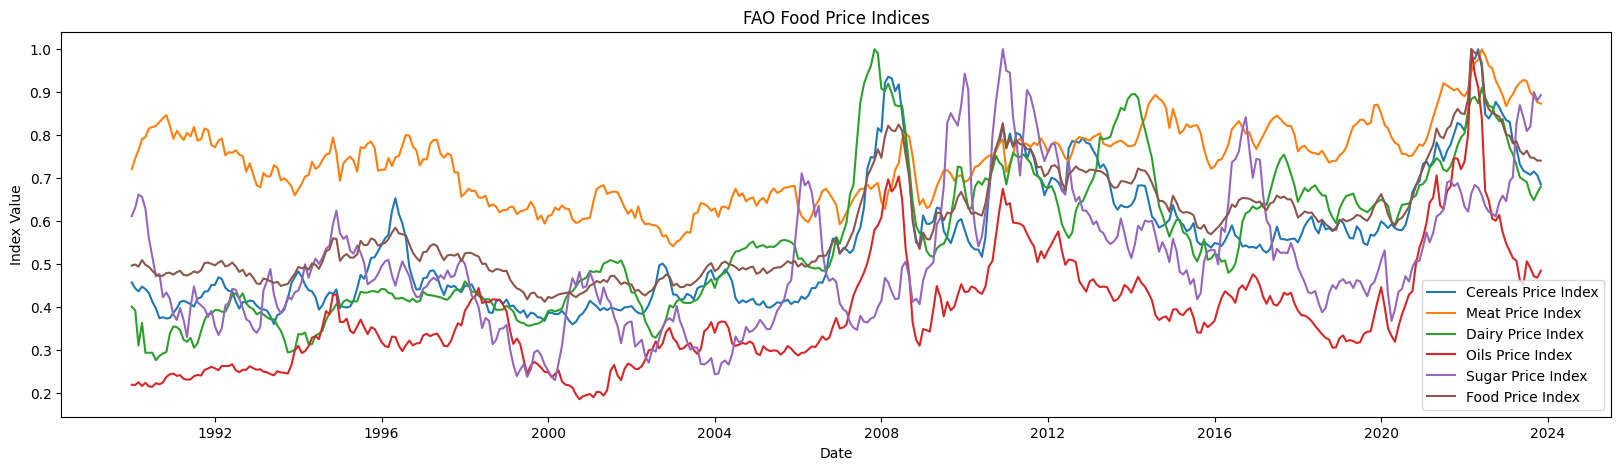

In [24]:
# Normalize each index based on its max value
data_cereal_price_index['Cereals Price Index'] = data_cereal_price_index['Cereals Price Index'] / data_cereal_price_index['Cereals Price Index'].max()
data_meat_price_index['Meat Price Index'] = data_meat_price_index['Meat Price Index'] / data_meat_price_index['Meat Price Index'].max()
data_dairy_price_index['Dairy Price Index'] = data_dairy_price_index['Dairy Price Index'] / data_dairy_price_index['Dairy Price Index'].max()
data_oil_price_index['Oils Price Index'] = data_oil_price_index['Oils Price Index'] / data_oil_price_index['Oils Price Index'].max()
data_sugar_price_index['Sugar Price Index'] = data_sugar_price_index['Sugar Price Index'] / data_sugar_price_index['Sugar Price Index'].max()
data_food_price_index['Food Price Index'] = data_food_price_index['Food Price Index'] / data_food_price_index['Food Price Index'].max()

# Plot the normalized indices
plt.plot(data_cereal_price_index['Month'], data_cereal_price_index['Cereals Price Index'], label='Cereals Price Index')
plt.plot(data_meat_price_index['Month'], data_meat_price_index['Meat Price Index'], label='Meat Price Index')
plt.plot(data_dairy_price_index['Month'], data_dairy_price_index['Dairy Price Index'], label='Dairy Price Index')
plt.plot(data_oil_price_index['Month'], data_oil_price_index['Oils Price Index'], label='Oils Price Index')
plt.plot(data_sugar_price_index['Month'], data_sugar_price_index['Sugar Price Index'], label='Sugar Price Index')
plt.plot(data_food_price_index['Month'], data_food_price_index['Food Price Index'], label='Food Price Index')

plt.rcParams["figure.figsize"] = (20,5)
plt.title('FAO Food Price Indices')
plt.ylabel('Index Value')
plt.xlabel('Date')
plt.legend()
plt.show()

**Export the Cleaned Data**

In [26]:
# if cleaned_data/food_indices does not exist, create it
if not os.path.exists('cleaned_data/food_indices'):
    os.makedirs('cleaned_data/food_indices')

data_cereal_price_index.to_csv('cleaned_data/food_indices/FAO_Cereal_Price_Index.csv')
data_meat_price_index.to_csv('cleaned_data/food_indices/FAO_Meat_Price_Index.csv')
data_dairy_price_index.to_csv('cleaned_data/food_indices/FAO_Dairy_Price_Index.csv')
data_oil_price_index.to_csv('cleaned_data/food_indices/FAO_Oil_Price_Index.csv')
data_sugar_price_index.to_csv('cleaned_data/food_indices/FAO_Sugar_Price_Index.csv')
data_food_price_index.to_csv('cleaned_data/food_indices/FAO_Food_Price_Index.csv')

### Part 1.3: Getting the Current Food Commodity Prices
The current value of different food commodities divided by country which is selling those food commodities. Choosing between food commodity pricing at the international, wholesale, or retail price point boils down to both the purpose and accuracy of this research. Respectively, this research aims to provide a model which can accurately predict the future price of food commodities for country food security, and more data (including futures data) is available at the international level. Therefore, the international price of food commodities is used as opposed to the other options.

**Data was pulled from the following website:** https://fpma.fao.org/giews/fpmat4/#/dashboard/tool/international

In [106]:
international_prices = pd.read_csv('all_data/International_Price_Data.csv')
international_prices['Date'] = pd.to_datetime(international_prices['Date'])
international_prices

,Date,"INTERNATIONAL PRICES, EXPORT, Argentina, Maize (Up River), USD/Kg","INTERNATIONAL PRICES, EXPORT, Argentina, Wheat (12%, Up River), USD/Kg","INTERNATIONAL PRICES, EXPORT, Australia, Meat: Bovine (Cow 90CL to US, f.a.s.), USD/Kg","INTERNATIONAL PRICES, EXPORT, Australia, Meat: Ovine (Medium trade lamb 18-20 Kg), USD/Kg","INTERNATIONAL PRICES, EXPORT, Australia (Eastern States), Barley (feed), USD/Kg","INTERNATIONAL PRICES, EXPORT, Australia (Eastern States), Wheat (ASW), USD/Kg","INTERNATIONAL PRICES, EXPORT, Bangladesh, Jute BWD (f.o.b. Mongla, at sight)/from 2006 Jute BTD (f.o.b Bangladesh Port), USD/Kg","INTERNATIONAL PRICES, EXPORT, Black Sea, Barley (feed), USD/Kg","INTERNATIONAL PRICES, EXPORT, Black Sea, Maize (feed), USD/Kg",...,"INTERNATIONAL PRICES, EXPORT, Unspecified, Rape oil (Dutch, f.o.b. ex-mill), USD/Kg","INTERNATIONAL PRICES, EXPORT, Unspecified, Rapeseed (Europe, 00, c.i.f. Hamburg), USD/Kg","INTERNATIONAL PRICES, EXPORT, Unspecified, Rapeseed meal (34%, Hamburg, f.o.b. ex-mill), USD/Kg","INTERNATIONAL PRICES, EXPORT, Unspecified, Soybean meal (44/45%, Hamburg, f.o.b. ex-mill), USD/Kg","INTERNATIONAL PRICES, EXPORT, Unspecified, Soybean oil (Dutch, f.o.b. ex-mill), USD/Kg","INTERNATIONAL PRICES, EXPORT, Unspecified, Sunflower oil (f.o.b. North West European Ports), USD/Kg","INTERNATIONAL PRICES, EXPORT, Unspecified, Sunflowerseed (EU, c.i.f. Amsterdam), USD/Kg","INTERNATIONAL PRICES, EXPORT, Uruguay, Rice (5% broken, long grain white, f.o.b., f.c.l.), USD/Kg","INTERNATIONAL PRICES, EXPORT, Viet Nam, Rice (25% broken), USD/Kg","INTERNATIONAL PRICES, EXPORT, Viet Nam, Rice (5% broken), USD/Kg"
0,2023-11-01,0.21320,0.25100,5.03689,2.72948,0.25185,0.27645,NaN,0.17495,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.77425,0.6080,0.63825
1,2023-10-01,0.22140,0.30420,5.13597,2.67446,0.25800,0.29632,0.71,0.17223,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.74425,0.5890,0.60150
2,2023-09-01,0.23670,0.31305,5.17345,3.16106,0.25667,0.29829,0.73,0.18810,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.73060,0.5870,0.60540
3,2023-08-01,0.22084,0.32176,5.02350,3.14367,0.24278,0.29365,0.70,0.18843,NaN,...,1.040,0.487,0.322,0.495,1.127,0.979,0.498,0.69725,0.5875,0.61425
4,2023-07-01,0.22740,0.33570,5.03421,3.33090,0.23433,0.29090,0.85,0.17733,0.1988,...,1.084,0.507,0.334,0.517,1.133,1.050,0.481,0.63425,0.4790,0.50400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,1990-05-01,NaN,NaN,2.25060,1.52462,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,1990-04-01,NaN,NaN,2.28440,1.44944,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404,1990-03-01,NaN,NaN,2.27153,1.32313,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
405,1990-02-01,NaN,NaN,2.29281,1.37325,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
# Given each column is a country's individual food commodity market
commodity_item_trends = {} # {commodity: {country: prices df w/ date}}

for i,column_name in enumerate(international_prices.columns):
    if i > 0: # Not the "Date" column
        # Get the individual attributes from the column name
        attributes = column_name.split(', ')
        port_type = attributes[1] #import/export
        country = attributes[2]
        commodity = attributes[3]
        unit = attributes[4] # USD/kg, USD/tonne, etc...

        # Get the individual column series
        price_trend = international_prices[['Date', column_name]]
        price_trend['Port Type'] = port_type
        price_trend['Unit'] = unit
        price_trend.rename(columns={column_name: 'Price'}, inplace=True)


        # If the commodity has not been recorded yet...
        if commodity not in commodity_item_trends:
            commodity_item_trends[commodity] = {}
        # If the country has not been recorded yet...
        if country not in commodity_item_trends[commodity]:
            commodity_item_trends[commodity][country] = price_trend


C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21436\762702537.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_trend['Port Type'] = port_type
C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21436\762702537.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_trend['Unit'] = unit
C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21436\762702537.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

In [141]:
# Normalize each commodity's price trend
for commodity in commodity_item_trends:
    for country in commodity_item_trends[commodity]:
        commodity_item_trends[commodity][country]['Price'] = commodity_item_trends[commodity][country]['Price'] / commodity_item_trends[commodity][country]['Price'].max()

C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21436\873111579.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commodity_item_trends[commodity][country]['Price'] = commodity_item_trends[commodity][country]['Price'] / commodity_item_trends[commodity][country]['Price'].max()


In [142]:
# Plot all the countries' price trends for a given commodity
def plot_commodity_trends(commodity):
    for country in commodity_item_trends[commodity]:
        price_trend = commodity_item_trends[commodity][country]
        plt.plot(price_trend['Date'], price_trend['Price'], label=country)
        plt.gcf().set_size_inches(20, 5)
    plt.legend()
    plt.title(commodity)
    plt.xlabel('Price')
    plt.ylabel('Date')
    plt.show()

print(commodity_item_trends.keys())
commodity_item_trends['Wheat (12%']['Argentina']

dict_keys(['Maize (Up River)', 'Wheat (12%', 'Meat: Bovine (Cow 90CL to US', 'Meat: Ovine (Medium trade lamb 18-20 Kg)', 'Barley (feed)', 'Wheat (ASW)', 'Jute BWD (f.o.b. Mongla', 'Maize (feed)', 'Urea (N fertilizer)', 'Wheat (feed)', 'Wheat (milling', 'Meat: Bovine (Fresh', 'Meat: Pig meat (Meat of swine', 'Meat: Poultry (Meat and edible offal. Fresh', 'Sisal (Brazil Bahia', 'Wheat (CWRS', 'Potassium chloride', 'Bananas (US East Coast - Main Brands Central America', 'Bananas (US East Coast - Other Brands Central America', 'Bananas (US West Coast - Main Brands Central America', 'Bananas (US West Coast - Other Brands Central America', 'Sisal (East African', 'Dairy: Butter (European & Oceania average indicative export prices', 'Dairy: Cheddar Cheese (European & Oceania average indicative export prices', 'Dairy: Skim Milk Powder (European & Oceania average indicative export prices', 'Dairy: Whole Milk Powder (European & Oceania average indicative export prices', 'Wheat (grade 1', 'Meat: P

,Date,Price,Port Type,Unit,Trend
0,2023-11-01,0.524720,EXPORT,Up River),NaN
1,2023-10-01,0.635936,EXPORT,Up River),NaN
2,2023-09-01,0.654437,EXPORT,Up River),NaN
3,2023-08-01,0.672646,EXPORT,Up River),NaN
4,2023-07-01,0.701787,EXPORT,Up River),NaN
...,...,...,...,...,...
402,1990-05-01,NaN,EXPORT,Up River),NaN
403,1990-04-01,NaN,EXPORT,Up River),NaN
404,1990-03-01,NaN,EXPORT,Up River),NaN
405,1990-02-01,NaN,EXPORT,Up River),NaN


#### Calculating the Residuals
Instead of going of previous commodity price datapoints, residuals from an overall weak trend can prove more useful to the training of a machine learning model, as supported by papers like [that written by Dr. Guerra Vallejos from MSOE](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=6FYxkMwAAAAJ&citation_for_view=6FYxkMwAAAAJ:zYLM7Y9cAGgC).

C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21436\3588017932.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_trend['Trend'] = np.poly1d(np.polyfit(days, price_trend['Price'], 5))(days)


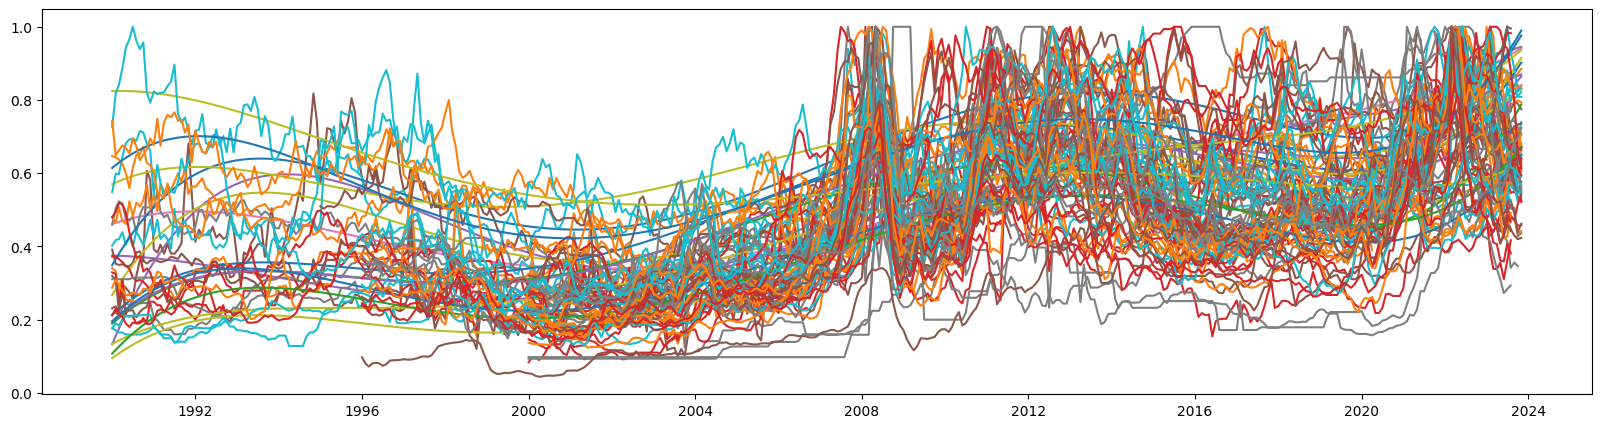

In [196]:
# Calculate the trend line (5th degree polynomial) for each commodity
for commodity in commodity_item_trends:
    for country in commodity_item_trends[commodity]:
        price_trend = commodity_item_trends[commodity][country]
        days = (price_trend['Date'] - price_trend['Date'].min()).dt.days
        price_trend['Trend'] = np.poly1d(np.polyfit(days, price_trend['Price'], 5))(days)

        # Plot the trend line
        plt.plot(price_trend['Date'], price_trend['Trend'], label='Trend')
        plt.plot(price_trend['Date'], price_trend['Price'], label='Price')

plt.show()

**Exporting the Cleaned Data**

In [193]:
# If cleaned_data/international_prices does not exist, create it
if not os.path.exists('cleaned_data/international_prices'):
    os.makedirs('cleaned_data/international_prices')

# Save each commodity's price trends to a csv file
for commodity in commodity_item_trends:
    for country in commodity_item_trends[commodity]:
        price_trend = commodity_item_trends[commodity][country]

        # Ensure there are no '/' in commodity or country
        commodity = commodity.replace('/', '-')
        country = country.replace('/', '-')

        price_trend.to_csv('cleaned_data/international_prices/{}_{}.csv'.format(commodity, country))

# Delete the extra files (Dairy, Meat)
for filename in os.listdir('cleaned_data/international_prices'):
    if filename.endswith('Dairy') or filename.endswith('Meat'):
        os.remove('cleaned_data/international_prices/{}'.format(filename))

### Part 1.4: Getting the Futures Trend Data
Futures are call options where traders estimate how the price will fluctuate in the future. The benefit to traders is that if they purchase a futures contract where the monetary value is less than the actual value at that time, the trader will purchase that commodity at a discount; however, the trader can cancel their contract if that actual value is lower than the contracted futures value. The benefit to the sellers is they will at least get the guaranteed premium income if the value of the commodity depreciates. Futures are important because they are currently the best indicator for how the traders believe the future of the market will perform in the short/medium term.

The futures data was pulled from Yahoo Finance. Based on the data available on this platform, the following futures data was pulled and will be used in the following analysis: sugar, corn, oat, wheat, rough rice, soybean oil, soybean, live cattle, coffee, and cotton. For individual download links to each of these datasets, please see the `Part 1: Data Collection` section of this notebook.

In [261]:
cocoa_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Cocoa_Futures.csv').dropna()
coffee_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Coffee_Futures.csv').dropna()
corn_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Corn_Futures.csv').dropna()
cotton_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Cotton_Futures.csv').dropna()
live_cattle_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Live-Cattle_Futures.csv').dropna()
oat_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Oat_Futures.csv').dropna()
rough_rice_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Rough-Rice_Futures.csv').dropna()
soybean_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Soybean_Futures.csv').dropna()
soybean_oil_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Soybean-Oil_Futures.csv').dropna()
wheat_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Wheat_Futures.csv').dropna()
sugar_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Sugar_Futures.csv').dropna()

In [262]:
# Convert all the dates to datetime objects
cocoa_futures['Date'] = pd.to_datetime(cocoa_futures['Date']).dt.date
coffee_futures['Date'] = pd.to_datetime(coffee_futures['Date']).dt.date
corn_futures['Date'] = pd.to_datetime(corn_futures['Date']).dt.date
cotton_futures['Date'] = pd.to_datetime(cotton_futures['Date']).dt.date
live_cattle_futures['Date'] = pd.to_datetime(live_cattle_futures['Date']).dt.date
oat_futures['Date'] = pd.to_datetime(oat_futures['Date']).dt.date
rough_rice_futures['Date'] = pd.to_datetime(rough_rice_futures['Date']).dt.date
soybean_futures['Date'] = pd.to_datetime(soybean_futures['Date']).dt.date
soybean_oil_futures['Date'] = pd.to_datetime(soybean_oil_futures['Date']).dt.date
wheat_futures['Date'] = pd.to_datetime(wheat_futures['Date']).dt.date
sugar_futures['Date'] = pd.to_datetime(sugar_futures['Date']).dt.date
cocoa_futures

,Date,Open,High,Low,Close,% Change,% Change vs Average,Volume
0,2000-01-01,840.00,875.00,757.00,763.00,0.00,-1.01,"97,087"
1,2000-02-01,775.00,805.00,730.00,759.00,-0.52,-1.53,"64,590"
2,2000-03-01,770.00,929.00,770.00,800.00,5.40,4.40,"64,659"
3,2000-04-01,785.00,850.00,740.00,764.00,-4.50,-5.51,"56,738"
4,2000-05-01,784.00,874.00,743.00,848.00,10.99,9.99,"57,609"
...,...,...,...,...,...,...,...,...
282,2023-07-01,"3,306.00","3,602.00","3,230.00","3,543.00",6.78,5.77,"301,797"
283,2023-08-01,"3,538.00","3,652.00","3,237.00","3,574.00",0.87,-0.13,"324,408"
284,2023-09-01,"3,638.00","3,874.00","3,398.00","3,418.00",-4.36,-5.37,"277,923"
285,2023-10-01,"3,432.00","3,880.00","3,373.00","3,794.00",11.00,9.99,"473,960"


In [263]:
# Convert the 'High' and 'Low' columns to numeric
for column_name in ['High', 'Low', 'Open', 'Close', 'Volume']:
    cocoa_futures[column_name] = pd.to_numeric(cocoa_futures[column_name].astype(str).str.replace(',', ''))
    coffee_futures[column_name] = pd.to_numeric(coffee_futures[column_name].astype(str).str.replace(',', ''))
    corn_futures[column_name] = pd.to_numeric(corn_futures[column_name].astype(str).str.replace(',', ''))
    cotton_futures[column_name] = pd.to_numeric(cotton_futures[column_name].astype(str).str.replace(',', ''))
    live_cattle_futures[column_name] = pd.to_numeric(live_cattle_futures[column_name].astype(str).str.replace(',', ''))
    oat_futures[column_name] = pd.to_numeric(oat_futures[column_name].astype(str).str.replace(',', ''))
    rough_rice_futures[column_name] = pd.to_numeric(rough_rice_futures[column_name].astype(str).str.replace(',', ''))
    soybean_futures[column_name] = pd.to_numeric(soybean_futures[column_name].astype(str).str.replace(',', ''))
    soybean_oil_futures[column_name] = pd.to_numeric(soybean_oil_futures[column_name].astype(str).str.replace(',', ''))
    wheat_futures[column_name] = pd.to_numeric(wheat_futures[column_name].astype(str).str.replace(',', ''))
    sugar_futures[column_name] = pd.to_numeric(sugar_futures[column_name].astype(str).str.replace(',', ''))

In [264]:
# Calculate an 'Average' column for each futures df based on the 'High' and 'Low' columns
cocoa_futures['Average'] = (cocoa_futures['High'] + cocoa_futures['Low']) / 2
coffee_futures['Average'] = (coffee_futures['High'] + coffee_futures['Low']) / 2
corn_futures['Average'] = (corn_futures['High'] + corn_futures['Low']) / 2
cotton_futures['Average'] = (cotton_futures['High'] + cotton_futures['Low']) / 2
live_cattle_futures['Average'] = (live_cattle_futures['High'] + live_cattle_futures['Low']) / 2
oat_futures['Average'] = (oat_futures['High'] + oat_futures['Low']) / 2
rough_rice_futures['Average'] = (rough_rice_futures['High'] + rough_rice_futures['Low']) / 2
soybean_futures['Average'] = (soybean_futures['High'] + soybean_futures['Low']) / 2
soybean_oil_futures['Average'] = (soybean_oil_futures['High'] + soybean_oil_futures['Low']) / 2
wheat_futures['Average'] = (wheat_futures['High'] + wheat_futures['Low']) / 2
sugar_futures['Average'] = (sugar_futures['High'] + sugar_futures['Low']) / 2
wheat_futures

,Date,Open,High,Low,Close,% Change,% Change vs Average,Volume,Average
0,2002-11-24,423.00,434.00,422.50,432.75,2.00,1.87,13415,428.250
1,2002-12-01,440.00,441.00,396.00,404.00,-6.64,-6.77,2555,418.500
2,2002-12-08,396.00,401.00,390.50,399.50,-1.11,-1.24,288,395.750
3,2002-12-15,404.25,408.50,372.00,377.25,-5.57,-5.70,11008,390.250
4,2002-12-22,377.00,384.00,366.25,370.50,-1.79,-1.92,12787,375.125
...,...,...,...,...,...,...,...,...,...
1096,2023-11-26,602.50,646.75,587.50,645.00,7.14,7.01,33793,617.125
1097,2023-12-03,644.75,673.00,644.75,655.75,1.67,1.54,212,658.875
1098,2023-12-10,627.00,662.00,626.75,642.75,-1.98,-2.11,41908,644.375
1099,2023-12-17,643.50,644.75,619.25,623.00,-3.07,-3.20,99769,632.000


In [265]:
# For each month/year, calculate the average price of each commodity

cocoa_futures['Date'] = pd.to_datetime(cocoa_futures['Date']); cocoa_futures['Month'] = cocoa_futures['Date'].dt.month; cocoa_futures['Year'] = cocoa_futures['Date'].dt.year
cocoa_futures = cocoa_futures.groupby(['Year', 'Month']).mean()

coffee_futures['Date'] = pd.to_datetime(coffee_futures['Date']); coffee_futures['Month'] = coffee_futures['Date'].dt.month; coffee_futures['Year'] = coffee_futures['Date'].dt.year
coffee_futures = coffee_futures.groupby(['Year', 'Month']).mean()

corn_futures['Date'] = pd.to_datetime(corn_futures['Date']); corn_futures['Month'] = corn_futures['Date'].dt.month; corn_futures['Year'] = corn_futures['Date'].dt.year
corn_futures = corn_futures.groupby(['Year', 'Month']).mean()

cotton_futures['Date'] = pd.to_datetime(cotton_futures['Date']); cotton_futures['Month'] = cotton_futures['Date'].dt.month; cotton_futures['Year'] = cotton_futures['Date'].dt.year
cotton_futures = cotton_futures.groupby(['Year', 'Month']).mean()

live_cattle_futures['Date'] = pd.to_datetime(live_cattle_futures['Date']); live_cattle_futures['Month'] = live_cattle_futures['Date'].dt.month; live_cattle_futures['Year'] = live_cattle_futures['Date'].dt.year
live_cattle_futures = live_cattle_futures.groupby(['Year', 'Month']).mean()

oat_futures['Date'] = pd.to_datetime(oat_futures['Date']); oat_futures['Month'] = oat_futures['Date'].dt.month; oat_futures['Year'] = oat_futures['Date'].dt.year
oat_futures = oat_futures.groupby(['Year', 'Month']).mean()

rough_rice_futures['Date'] = pd.to_datetime(rough_rice_futures['Date']); rough_rice_futures['Month'] = rough_rice_futures['Date'].dt.month; rough_rice_futures['Year'] = rough_rice_futures['Date'].dt.year
rough_rice_futures = rough_rice_futures.groupby(['Year', 'Month']).mean()

soybean_futures['Date'] = pd.to_datetime(soybean_futures['Date']); soybean_futures['Month'] = soybean_futures['Date'].dt.month; soybean_futures['Year'] = soybean_futures['Date'].dt.year
soybean_futures = soybean_futures.groupby(['Year', 'Month']).mean()

soybean_oil_futures['Date'] = pd.to_datetime(soybean_oil_futures['Date']); soybean_oil_futures['Month'] = soybean_oil_futures['Date'].dt.month; soybean_oil_futures['Year'] = soybean_oil_futures['Date'].dt.year
soybean_oil_futures = soybean_oil_futures.groupby(['Year', 'Month']).mean()

wheat_futures['Date'] = pd.to_datetime(wheat_futures['Date']); wheat_futures['Month'] = wheat_futures['Date'].dt.month; wheat_futures['Year'] = wheat_futures['Date'].dt.year
wheat_futures = wheat_futures.groupby(['Year', 'Month']).mean()

sugar_futures['Date'] = pd.to_datetime(sugar_futures['Date']); sugar_futures['Month'] = sugar_futures['Date'].dt.month; sugar_futures['Year'] = sugar_futures['Date'].dt.year
sugar_futures = sugar_futures.groupby(['Year', 'Month']).mean()



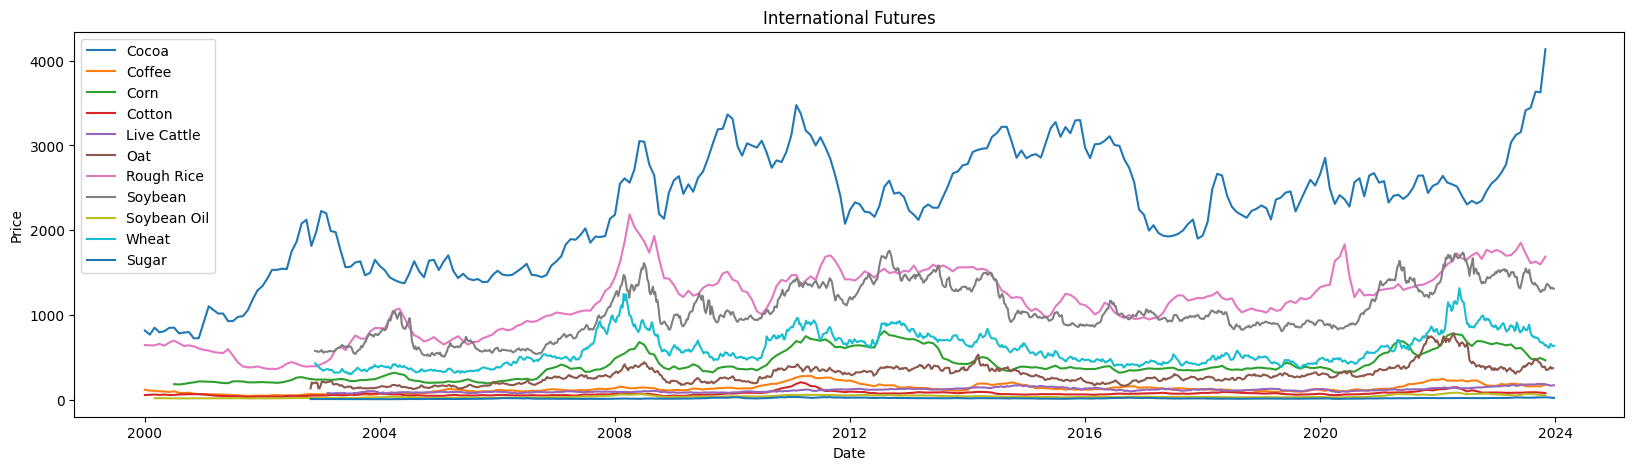

In [247]:
# Plot the average price for each future
plt.plot(cocoa_futures['Date'], cocoa_futures['Average'], label='Cocoa')
plt.plot(coffee_futures['Date'], coffee_futures['Average'], label='Coffee')
plt.plot(corn_futures['Date'], corn_futures['Average'], label='Corn')
plt.plot(cotton_futures['Date'], cotton_futures['Average'], label='Cotton')
plt.plot(live_cattle_futures['Date'], live_cattle_futures['Average'], label='Live Cattle')
plt.plot(oat_futures['Date'], oat_futures['Average'], label='Oat')
plt.plot(rough_rice_futures['Date'], rough_rice_futures['Average'], label='Rough Rice')
plt.plot(soybean_futures['Date'], soybean_futures['Average'], label='Soybean')
plt.plot(soybean_oil_futures['Date'], soybean_oil_futures['Average'], label='Soybean Oil')
plt.plot(wheat_futures['Date'], wheat_futures['Average'], label='Wheat')
plt.plot(sugar_futures['Date'], sugar_futures['Average'], label='Sugar')

plt.rcParams["figure.figsize"] = (20,5)
plt.title('International Futures')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend()
plt.show()

**Export the Cleaned Data**

In [266]:
# If 'cleaned_data/futures' does not exist, create it
if not os.path.exists('cleaned_data/futures'):
    os.makedirs('cleaned_data/futures')

# Save the csv data
cocoa_futures.to_csv('cleaned_data/futures/ICE_Cocoa_Futures.csv')
coffee_futures.to_csv('cleaned_data/futures/ICE_Coffee_Futures.csv')
corn_futures.to_csv('cleaned_data/futures/CBOT_Corn_Futures.csv')
cotton_futures.to_csv('cleaned_data/futures/ICE_Cotton_Futures.csv')
live_cattle_futures.to_csv('cleaned_data/futures/CME_Live-Cattle_Futures.csv')
oat_futures.to_csv('cleaned_data/futures/CBOT_Oat_Futures.csv')
rough_rice_futures.to_csv('cleaned_data/futures/CBOT_Rough-Rice_Futures.csv')
soybean_futures.to_csv('cleaned_data/futures/CBOT_Soybean_Futures.csv')
soybean_oil_futures.to_csv('cleaned_data/futures/CBOT_Soybean-Oil_Futures.csv')
wheat_futures.to_csv('cleaned_data/futures/CBOT_Wheat_Futures.csv')
sugar_futures.to_csv('cleaned_data/futures/ICE_Sugar_Futures.csv')

### Part 1.5: Getting the Harvest Data
Harvest data is important for predicting the actual price of food commodities in the future, as it is a direct indicator of the supply of food commodities. The more food commodities available, the lower the price will be. This data is also important because it can be used to determine the overall trend of the market, as well as the overall trend of the market in a specific country.
* **Crops and Livestock Products:** https://www.fao.org/faostat/en/#data/QCL; 
* **Value of Agricultural Production:** https://www.fao.org/faostat/en/#data/QV; Values of agricultural production are calculated based on production data of primary commodities from Production domain and producer prices from Prices domain. The livestock value of production is measured in terms of indigenous meat. **WHAT WILL BE USED**
* **Production Indices:** https://www.fao.org/faostat/en/#data/QI; The FAO indices of agricultural production show the relative level of the aggregate volume of agricultural production for each year in comparison with the base period 2014-2016. Indices for meat production are computed based on data for production from indigenous animals.

Note, this data is already normalized by the FAO.

In [43]:
production_data = pd.read_csv('all_data/Value_of_Production_E_All_Data_(Normalized)/Value_of_Production_E_All_Data_(Normalized).csv', encoding='ISO-8859-1')
production_data = production_data[['Area', 'Item', 'Element', 'Year', 'Unit', 'Value', 'Flag']]
production_data

,Area,Item,Element,Year,Unit,Value,Flag
0,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1976,1000 Int. $,49550.0,E
1,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1977,1000 Int. $,45505.0,E
2,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1978,1000 Int. $,60673.0,E
3,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1979,1000 Int. $,53089.0,E
4,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1980,1000 Int. $,50055.0,E
...,...,...,...,...,...,...,...
2793884,Net Food Importing Developing Countries,Vegetables Primary,Gross Production Value (constant 2014-2016 tho...,2017,1000 US$,24659857.0,E
2793885,Net Food Importing Developing Countries,Vegetables Primary,Gross Production Value (constant 2014-2016 tho...,2018,1000 US$,25312231.0,E
2793886,Net Food Importing Developing Countries,Vegetables Primary,Gross Production Value (constant 2014-2016 tho...,2019,1000 US$,25924331.0,E
2793887,Net Food Importing Developing Countries,Vegetables Primary,Gross Production Value (constant 2014-2016 tho...,2020,1000 US$,27170537.0,E


In [44]:
flag_lookup_table = pd.read_csv('all_data/Production_Crops_Livestock_E_All_Data_(Normalized)/Production_Crops_Livestock_E_Flags.csv', encoding='ISO-8859-1')
flag_lookup_table

,Flag,Description
0,A,Official figure
1,E,Estimated value
2,I,Imputed value
3,M,Missing value (data cannot exist; not applicable)
4,X,Figure from international organizations


In [45]:
# Merge the production_data and flag_lookup_table dataframes
production_data = production_data.merge(flag_lookup_table, on='Flag', how='left')

# Drop the 'Flag' column and rename the 'Description' column to 'Flag'
production_data.drop(columns=['Flag'], inplace=True)
production_data.rename(columns={'Description': 'Flag'}, inplace=True)
production_data

,Area,Item,Element,Year,Unit,Value,Flag
0,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1976,1000 Int. $,49550.0,Estimated value
1,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1977,1000 Int. $,45505.0,Estimated value
2,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1978,1000 Int. $,60673.0,Estimated value
3,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1979,1000 Int. $,53089.0,Estimated value
4,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1980,1000 Int. $,50055.0,Estimated value
...,...,...,...,...,...,...,...
2793884,Net Food Importing Developing Countries,Vegetables Primary,Gross Production Value (constant 2014-2016 tho...,2017,1000 US$,24659857.0,Estimated value
2793885,Net Food Importing Developing Countries,Vegetables Primary,Gross Production Value (constant 2014-2016 tho...,2018,1000 US$,25312231.0,Estimated value
2793886,Net Food Importing Developing Countries,Vegetables Primary,Gross Production Value (constant 2014-2016 tho...,2019,1000 US$,25924331.0,Estimated value
2793887,Net Food Importing Developing Countries,Vegetables Primary,Gross Production Value (constant 2014-2016 tho...,2020,1000 US$,27170537.0,Estimated value


In [53]:
# Divide up the production_data by Item
production_data_by_item = {} # {commodity: {country: prices df w/ date}}

for i,row in production_data.iterrows():
    item = row['Item']
    country = row['Area']

    # Remove all "'" from item name
    item = item.replace("'", "")

    # If the item has not been recorded yet...
    if item not in production_data_by_item:
        production_data_by_item[item] = {}
    # If the country has not been recorded yet...
    if country not in production_data_by_item[item]:
        df = production_data[(production_data['Item'] == item) & (production_data['Area'] == country)]
        production_data_by_item[item][country] = df

In [56]:
# Plot all the countries' price trends for a given commodity
def plot_production_trends(item):
    for country in production_data_by_item[item]:
        production_trend = production_data_by_item[item][country]
        plt.plot(production_trend['Year'], production_trend['Value'], label=country)
        plt.gcf().set_size_inches(20, 5)
    plt.legend()
    plt.title(item)
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.show()

print(production_data_by_item.keys())

dict_keys(['Almonds, in shell', 'Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw', 'Apples', 'Apricots', 'Barley', 'Cantaloupes and other melons', 'Figs', 'Game meat, fresh, chilled or frozen', 'Grapes', 'Hen eggs in shell, fresh', 'Linseed', 'Maize (corn)', 'Meat of camels, fresh or chilled (indigenous)', 'Meat of cattle with the bone, fresh or chilled (indigenous)', 'Meat of chickens, fresh or chilled (indigenous)', 'Meat of goat, fresh or chilled (indigenous)', 'Meat of sheep, fresh or chilled (indigenous)', 'Millet', 'Natural honey', 'Olives', 'Onions and shallots, dry (excluding dehydrated)', 'Oranges', 'Other berries and fruits of the genus vaccinium n.e.c.', 'Other citrus fruit, n.e.c.', 'Other fruits, n.e.c.', 'Other nuts (excluding wild edible nuts and groundnuts), in shell, n.e.c.', 'Other pulses n.e.c.', 'Other stimulant, spice and aromatic crops, n.e.c.', 'Other stone fruits', 'Other vegetables, fresh n.e.c.', 'Peaches and nectarines', 'Pears', 'Pi

**Export the Cleaned Data**

In [ ]:
# Save the production_data_by_item to individual csv files

# If cleaned_data/production_data does not exist, create it
if not os.path.exists('cleaned_data/production_data'):
    os.makedirs('cleaned_data/production_data')

for item in production_data_by_item:
    for country in production_data_by_item[item]:
        df = production_data_by_item[item][country]

        # Ensure there are no '/' in commodity or country
        item = item.replace('/', '-')
        country = country.replace('/', '-')

        df.to_csv('cleaned_data/production_data/{}_{}.csv'.format(item, country))

### Part 1.6: Getting the Articles & Article Sentiment
Different articles submitted by credible economic platforms can be used as part of the model's predictions for the future market, as well as even social media to capture public sentiment ([as shown in this paper](https://arxiv.org/pdf/2310.18706.pdf)). Sentiment of these articles is an effective, efficient method of processing large amounts of text for stock predictions. A research paper outlining the effectiveness of utilizing sentiment for stock prediction can be found [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3649137)

Therefore, in order to get the sentiment of these articles (listed at the beginning of `Part 1: Data Collection`), a Sentiment Analysis model specializing in large-document sentiment analysis will be downloaded from Hugging Face and varying, professional sources/articles will be parseed. The sentiment model that will be used is: [distilroberta-finetuned-financial-news-sentiment-analysis](https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis). This model was chosen both for its ability to parse larger corpora of text and its ability to parse financial information accurately.

As for specific documents used in this dataset, the following documents were used:
* **FAO Agricultural Outlook:** https://www.fao.org/documents/card/en/c/cc6361en
    * [2023-2032](https://www.fao.org/documents/card/en/c/cc6361en), [2022-2031](http://www.fao.org/documents/card/en/c/cc0308en), [2021-2030](http://www.fao.org/documents/card/en/c/cb5332en), [2020-2029](https://www.fao.org/documents/card/en/c/ca8861en), [2019-2028](http://www.fao.org/documents/card/en/c/ca4076en), [2018-2027](http://www.fao.org/documents/card/en/c/i9166en), [2017-2026](https://www.fao.org/documents/card/en/c/9063b6e9-e46e-463e-86bd-8cb3ec477d31), [2016-2025](https://www.fao.org/documents/card/en/c/f0589695-58d9-425c-8be2-7dc065e5602f), [2015-2024](https://www.fao.org/documents/card/en/c/3db5270d-5f6c-4e82-9f1f-f03b3650d51c)
    * **NOTE:** Each of these documents contains an executive summary which can be used to reduce data complexity and processing time.
* **FAO Food Outlook:** https://www.fao.org/documents/card/en/c/cb4471en  
* **FAO Social Media:** https://twitter.com/FAO


In [59]:
# Load model directly
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

c:\Users\paulsonb\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\paulsonb\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

In [145]:
# Read through all the pdfs stored in the 'all_data/Econmic_PDFs' directory and extract their text into a dictionary
pdfs = {} # {'filename': ['text', 'sentiment']}

def determine_pdf_sentiment(directory = 'all_data/Economic_PDFs'):
    """
    Given a directory of pdfs, determine the sentiment of each pdf and store it in a dictionary
    :param directory: the directory containing the pdfs
    """
    for filename in os.listdir(directory):
        if filename.endswith('.pdf'):
            pdf_file = open('{}/{}'.format(directory, filename), 'rb')
            pdf_reader = PyPDF2.PdfReader(pdf_file)
            pdf_text = ''

            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                pdf_text += page.extract_text()

            # Determine the sentiment of the document
            tokenized_text = tokenizer(pdf_text, return_tensors="pt", truncation=True, padding=True)
            outputs = model(**tokenized_text)

            # Based on the logit output, determine correlating sentiment
            probabilities = F.softmax(outputs.logits, dim=1)
            prediction = torch.argmax(probabilities, dim=1)
            sentiment = "positive" if prediction.item() == 1 else "negative"
            print("File ", filename, " is sentiment: ", sentiment)

            pdfs[filename] = [pdf_text, sentiment]

In [146]:
determine_pdf_sentiment()

File  2000_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2001_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2002_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2003-04_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2005_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2006_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2007_State-of-Food-and-Agriculture.pdf  is sentiment:  negative
File  2008_State-of-Food-and-Agriculture.pdf  is sentiment:  negative
File  2009_State-of-Food-and-Agriculture.pdf  is sentiment:  negative
File  2010-11_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2012_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2013_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2014_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2015_State-of-Food-and-Agriculture.pdf  is sentiment:  negative
File  2016_Sta

In [286]:
# Based on the pdfs dictionary, create a csv file with the columns 'File Name' and 'Sentiment'
pdf_sentiment_df = pd.DataFrame.from_dict(pdfs, orient='index', columns=['Text', 'Sentiment'])
pdf_sentiment_df.index.name = 'File Name'

# Convert the index to the column 'File Name'
pdf_sentiment_df.reset_index(inplace=True)

# Make the sentiment 1 for positive and -1 for negative
pdf_sentiment_df['Sentiment'] = pdf_sentiment_df['Sentiment'].apply(lambda x: 1 if x == 'positive' else -1)
pdf_sentiment_df['Year'] = pdf_sentiment_df['File Name'].apply(lambda x: int(x[:4]))

**Export the Cleaned Data**

In [288]:
# Make the pdf_sentiment directory if it does not exist
if not os.path.exists('cleaned_data/pdf_sentiment'):
    os.makedirs('cleaned_data/pdf_sentiment')

pdf_sentiment_df.to_csv('cleaned_data/pdf_sentiment/State_of_Food_and_Agriculture.csv')

### Part 1.7: Building a Finalized Dataframe
The finalized dataframe will be used to easily understand which variables are reserved for input/output alongside the associated date as a transformer is trained to learn the time series patterns. Manipulating the data into this dataframe will also allow for easy data visualization and analysis in the next section (`Part 2: Statistical Analysis`) of this notebook analysis. Here is a breakdown of the final dataframe(s):

* **Output Variable:**
    * International Prices (particular `commodity`, `country`, `month`, `unit`); `cleaned_data/international_prices/`
* **Input Variables:**
    * PROTEUS Index (particular `year`, `country`); `PROTEUS_Index_data.csv`
    * Food Price Indices (particular `index` (industry), `month`); `cleaned_data/food_indices/`
    * Futures Data (particular `commodity`, `month`); `cleaned_data/futures/`
    * Harvest Data (particular `commodity`, `region/country`, `year`); `cleaned_data/production_data/`
    * Sentiment (particular `year`); see `Part 1.6` for more info

**NOTE:** Since there is a large amount of data across varying regions, such as over 1000 csvs existing for production data alone across all the different regions, only specific regions will be chosen for early experiments. Later experiments can utilize the full dataset once a baseline model has been developed to iterate on.


In [300]:
def pull_model_data(iso, commodity_file, special_index_file, futures_file, harvest_file):
    """
    Given particular file names, format the data into a dataframe for easy
    statistical analysis in the next section and easy ML input
    :param str iso: The iso of the country (ARG, USA, etc...)
    :param str commodity_file: Name of the file containing the commodity pricing data
    :param str special_index_file: The other index (other than general food index) used for this commodity
    :para str futures_file: The related futures of this commodity
    :param str harvest_file: The related harvest data of this commodity
    :return: A dataframe containing all the data
    """
    ### Pulling the data
    commodity_price_data = pd.read_csv('cleaned_data/international_prices/{}'.format(commodity_file))
    commodity_price_data['Date'] = pd.to_datetime(commodity_price_data['Date'])
    commodity_price_data['Month'] = commodity_price_data['Date'].dt.month
    commodity_price_data['Year'] = commodity_price_data['Date'].dt.year
    commodity_price_data.drop(columns=['Unnamed: 0'], inplace=True)

    proteus_data = pd.read_csv('cleaned_data/PROTEUS_Index_data.csv')
    proteus_data = proteus_data[proteus_data['Iso'] == iso]

    food_index_data = pd.read_csv('cleaned_data/food_indices/FAO_Food_Price_Index.csv')
    special_index_data = pd.read_csv('cleaned_data/food_indices/{}'.format(special_index_file))
    futures_data = pd.read_csv('cleaned_data/futures/{}'.format(futures_file))
    harvest_data = pd.read_csv('cleaned_data/production_data/{}'.format(harvest_file))
    fao_agriculture_sentiment_data = pd.read_csv('cleaned_data/pdf_sentiment/State_of_Food_and_Agriculture.csv')

    ### Merging the data
    # Merge the dataframes based on Date/Year
    model_data = commodity_price_data.merge(proteus_data, on='Year', how='left')
    model_data = model_data.dropna(subset=['Price', 'Proteus2']) # Some PROTEUS/Price data may not be available for certain years; drop it

    # Merge the Food-Index data and Cereal-Index data based on Date
    food_index_data['Date'] = pd.to_datetime(food_index_data['Month']); food_index_data.drop(columns=['Unnamed: 0', 'Month'], inplace=True)
    special_index_data['Date'] = pd.to_datetime(special_index_data['Month']); special_index_data.drop(columns=['Unnamed: 0', 'Month'], inplace=True)
    model_data = model_data.merge(food_index_data, on='Date', how='left')
    model_data = model_data.merge(special_index_data, on='Date', how='left')

    # Merge the futures data based on 'Month' and 'Year (Wheat futures)
    wheat_futures_data = futures_data[['Year', 'Month', 'Average']]
    wheat_futures_data['Date'] = pd.to_datetime(wheat_futures_data['Year'].astype(str) + '-' + wheat_futures_data['Month'].astype(str))
    wheat_futures_data.drop(columns=['Year', 'Month'], inplace=True)
    wheat_futures_data.rename(columns={'Average': 'Wheat Futures'}, inplace=True)
    model_data = model_data.merge(wheat_futures_data, on='Date', how='left')
    model_data = model_data.dropna(subset=['Wheat Futures']) # Some futures data may not be available for certain years; drop it

    # Merge the harvest data based on 'Year'
    harvest_data = harvest_data[['Year', 'Value']]
    harvest_data.rename(columns={'Value': 'Harvest'}, inplace=True)
    model_data = model_data.merge(harvest_data, on='Year', how='left')

    # Merge the fao_agriculture_sentiment_data based on 'Year'
    fao_agriculture_sentiment_data = fao_agriculture_sentiment_data[['Year', 'Sentiment']]
    model_data = model_data.merge(fao_agriculture_sentiment_data, on='Year', how='left')

    # Final format for model
    model_data = model_data[['Date', 'Price', 'Proteus2', 'Food Price Index', 'Cereals Price Index', 'Wheat Futures', 'Harvest', 'Sentiment']]
    return model_data

In [301]:
model_data = pull_model_data('ARG', 'Wheat (12%_Argentina.csv', 'FAO_Cereal_Price_Index.csv', 'CBOT_Wheat_Futures.csv', 'Wheat_Argentina.csv')
model_data

C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21436\2589848950.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wheat_futures_data['Date'] = pd.to_datetime(wheat_futures_data['Year'].astype(str) + '-' + wheat_futures_data['Month'].astype(str))
C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21436\2589848950.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wheat_futures_data.drop(columns=['Year', 'Month'], inplace=True)
C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21436\2589848950.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,Date,Price,Proteus2,Food Price Index,Cereals Price Index,Wheat Futures,Harvest,Sentiment
0,2016-12-01,0.351207,0.252506,0.647473,0.540047,405.90625,2679728.0,1.0
1,2016-12-01,0.351207,0.252506,0.647473,0.540047,405.90625,23367493.0,1.0
2,2016-12-01,0.351207,0.252506,0.647473,0.540047,405.90625,2157181.0,1.0
3,2016-11-01,0.368768,0.252506,0.651951,0.538869,408.40625,2679728.0,1.0
4,2016-11-01,0.368768,0.252506,0.651951,0.538869,408.40625,23367493.0,1.0
...,...,...,...,...,...,...,...,...
787,2002-11-01,0.284833,0.292393,0.476008,0.490577,428.25000,3653782.0,1.0
788,2002-11-01,0.284833,0.292393,0.476008,0.490577,428.25000,6109417.0,1.0
789,2002-11-01,0.284833,0.292393,0.476008,0.490577,428.25000,31861336.0,1.0
790,2002-11-01,0.284833,0.292393,0.476008,0.490577,428.25000,1994419.0,1.0


In [295]:
model_data.to_csv('cleaned_data/argentina_wheat_model_data.csv')

#### Time-Series Formatting Experiments
The following cells are the final step in formatting `model_data` to be used with the Transformer model for time-series prediction. This is because the individual rows must encapsulate entire series worth of data instead of single datapoints. Therefore, there are two possible ways of formatting the data:

1. **n-Number Datapoints:** Given a particular commodity item's trend data, grab `n`-number of price datapoints and use those as the input to the model with the next value in the series as the output.
2. **All Past Data:** Given a particular point in time of the commodity item's trend data, grab all the price datapoints up to that point in time and use those as the input to the model with the next value in the series as the output.

## Part 2: Statistical Analysis
Statistical Analysis is an important part of data science and machine learning in order to determine which features are important to the model and which features can be removed. This section will analyze the data collected in `Part 1: Data Collection` and determine which features are important to the model and which features can be removed. For each statistical test, an alpha value ($\alpha$) of `0.01` will be used. The null hypothesis ($H_0$) will be that the two variables are not correlated, and the alternative hypothesis ($H_1$) will be that the two variables are correlated. If the p-value is less than the alpha value, then the null hypothesis will be rejected and the alternative hypothesis will be accepted. 

To summarize the analysis that will be performed, here is a breakdown of each section:
* **Part 2.1: PROTEUS Index Analysis:** This section will analyze how the PROTEUS index has changed over time and determine if it is a good indicator for fluctuating international food prices. For this section, the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) will be used.
* **Part 2.2: Food Indices Analysis:** This section will analyze how the food indices have changed over time and determine if they are good indicators for fluctuating international food prices. For this section, the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) will be used.
* **Part 2.3: Current Food Commodity Prices Analysis:** This section will analyze how the current food commodity prices have changed over time and determine if they are good indicators for fluctuating international food prices from other regions and food industries. For this section, the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) will be used.
* **Part 2.4: Futures Trend Analysis:** This section will analyze how the futures trend data has changed over time and determine if they are good indicators for fluctuating international food prices. For this section, the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) will be used.
* **Part 2.5: Harvest Data Analysis:** This section will analyze how the harvest data has changed over time and determine if they are good indicators for fluctuating international food prices. For this section, the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) will be used.
* **Part 2.6: Articles & Article Sentiment Analysis:** This section will analyze how the articles and article sentiment has changed over time and determine if they are good indicators for fluctuating international food prices. _______________________

As a reminder, all data has already been cleaned in `Part 1: Data Collection`, including the normalization of the data. Since this research is focused on anomaly detection for the purpose of warning countries of potential food insecurity, data outliers will not be removed.

In [152]:
ALPHA_VALUE = 0.01

### Part 2.1: PROTEUS Index Analysis
This section will analyze how the PROTEUS index has changed over time and determine if it is a good indicator for fluctuating international food prices. For this section, the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) will be used.

**Conclusion:** 


In [ ]:
# Given a food commodity in the directory 'cleaned_data/international_prices', determine the region and match the associated PROTEUS value


In [ ]:
# (FROM THE NOTEBOOK I MADE WITH SYDNEY)

# Determine the statistical relationship between the food index and each of the other indices using Spearman's Correlation Coefficient
food_v_cereal = spearmanr(data_food_price_index['Food Price Index'], data_cereal_price_index['Cereals Price Index'])
food_v_meat = spearmanr(data_food_price_index['Food Price Index'], data_meat_price_index['Meat Price Index'])
food_v_dairy = spearmanr(data_food_price_index['Food Price Index'], data_dairy_price_index['Dairy Price Index'])
food_v_oil = spearmanr(data_food_price_index['Food Price Index'], data_oil_price_index['Oils Price Index'])
food_v_sugar = spearmanr(data_food_price_index['Food Price Index'], data_sugar_price_index['Sugar Price Index'])

print('The Relationship between the food index and the cereal index is significant:', food_v_cereal[1] < ALPHA_VALUE, "(p-value:", food_v_cereal[1], ")")
print('The Relationship between the food index and the meat index is significant:', food_v_meat[1] < ALPHA_VALUE, "(p-value:", food_v_meat[1], ")")
print('The Relationship between the food index and the dairy index is significant:', food_v_dairy[1] < ALPHA_VALUE, "(p-value:", food_v_dairy[1], ")")
print('The Relationship between the food index and the oil index is significant:', food_v_oil[1] < ALPHA_VALUE, "(p-value:", food_v_oil[1], ")")
print('The Relationship between the food index and the sugar index is significant:', food_v_sugar[1] < ALPHA_VALUE, "(p-value:", food_v_sugar[1], ")")


### Part 2.2: Food Indices Analysis
In this section we'll be looking at the relationship between each price index and the other prices indices, recognizing how closely the price indices match each other as the economy changes throughout the years. Normalized, non-normal, numerical data will be used, meaning the statistical test that will be used will be the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient). This statistical test uses a monotonic function and performs well even with non-normal data.

**Conclusion:** Based on the results achieved in the last cell of this section (`Part 3.1`), each of the indices are correlating, meaning they all have statistically significant similarity between each other. Understanding this, each index is a good signal for the overall food index, meaning the food index could be used as a signal in the machine learning model, including information about the other indices.

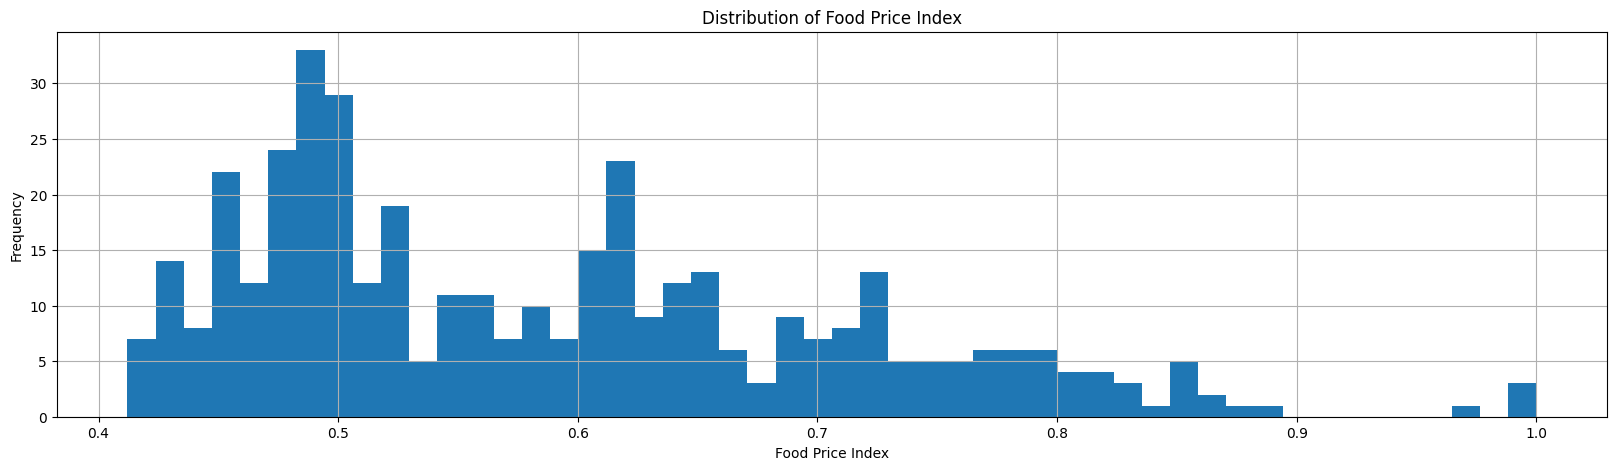

In [147]:
# Determine if the data is normally distributed (histogram of index values, binned by value)
data_food_price_index['Food Price Index'].hist(bins=50)
plt.xlabel('Food Price Index')
plt.ylabel('Frequency')
plt.title('Distribution of Food Price Index')
plt.show()

# Based on the histogram below, the data is not normally distributed; it does not follow a bell curve and there are multiple peaks within the distribution.

C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21436\4068553017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_food_price_index['Food Price Index'] = data_food_price_index['Food Price Index'] / data_food_price_index['Food Price Index'].max()
C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21436\4068553017.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cereal_price_index['Cereals Price Index'] = data_cereal_price_index['Cereals Price Index'] / data_cereal_price_index['Cereals Price Index']

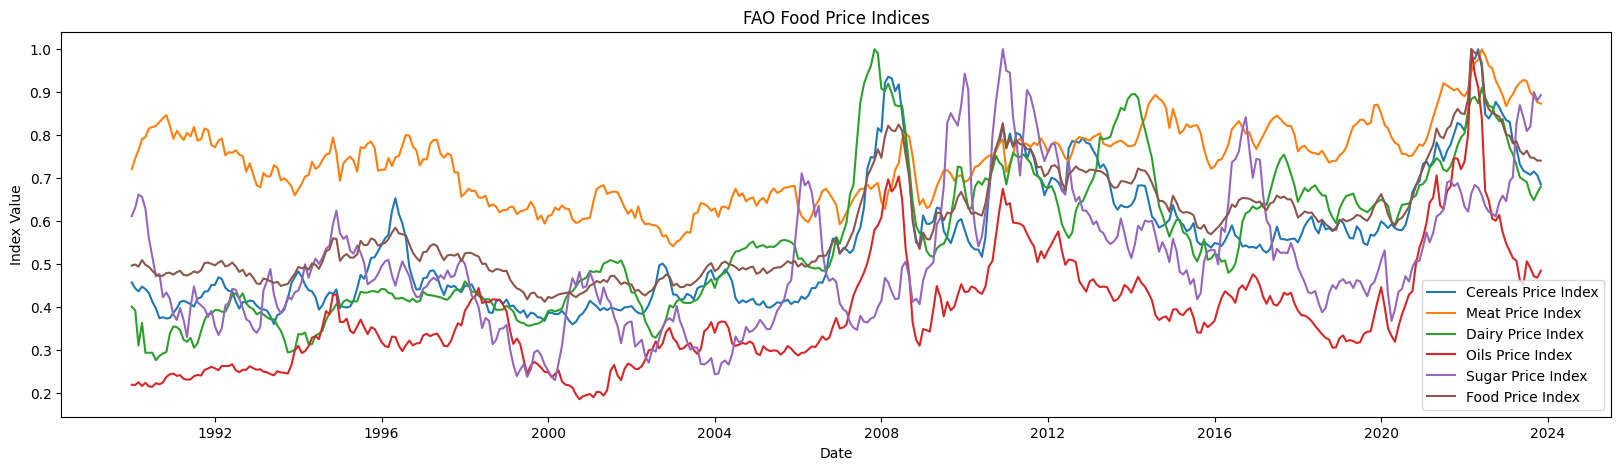

In [148]:
# Normalize the different indices by dividing each index value by the max value of that index
data_food_price_index['Food Price Index'] = data_food_price_index['Food Price Index'] / data_food_price_index['Food Price Index'].max()
data_cereal_price_index['Cereals Price Index'] = data_cereal_price_index['Cereals Price Index'] / data_cereal_price_index['Cereals Price Index'].max()
data_meat_price_index['Meat Price Index'] = data_meat_price_index['Meat Price Index'] / data_meat_price_index['Meat Price Index'].max()
data_dairy_price_index['Dairy Price Index'] = data_dairy_price_index['Dairy Price Index'] / data_dairy_price_index['Dairy Price Index'].max()
data_oil_price_index['Oils Price Index'] = data_oil_price_index['Oils Price Index'] / data_oil_price_index['Oils Price Index'].max()
data_sugar_price_index['Sugar Price Index'] = data_sugar_price_index['Sugar Price Index'] / data_sugar_price_index['Sugar Price Index'].max()

# Plot the normalized indices
plt.plot(data_cereal_price_index['Month'], data_cereal_price_index['Cereals Price Index'], label='Cereals Price Index')
plt.plot(data_meat_price_index['Month'], data_meat_price_index['Meat Price Index'], label='Meat Price Index')
plt.plot(data_dairy_price_index['Month'], data_dairy_price_index['Dairy Price Index'], label='Dairy Price Index')
plt.plot(data_oil_price_index['Month'], data_oil_price_index['Oils Price Index'], label='Oils Price Index')
plt.plot(data_sugar_price_index['Month'], data_sugar_price_index['Sugar Price Index'], label='Sugar Price Index')
plt.plot(data_food_price_index['Month'], data_food_price_index['Food Price Index'], label='Food Price Index')

plt.rcParams["figure.figsize"] = (20,5)
plt.title('FAO Food Price Indices')
plt.ylabel('Index Value')
plt.xlabel('Date')
plt.legend()
plt.show()

In [153]:
# Determine the statistical relationship between the food index and each of the other indices using Spearman's Correlation Coefficient
food_v_cereal = spearmanr(data_food_price_index['Food Price Index'], data_cereal_price_index['Cereals Price Index'])
food_v_meat = spearmanr(data_food_price_index['Food Price Index'], data_meat_price_index['Meat Price Index'])
food_v_dairy = spearmanr(data_food_price_index['Food Price Index'], data_dairy_price_index['Dairy Price Index'])
food_v_oil = spearmanr(data_food_price_index['Food Price Index'], data_oil_price_index['Oils Price Index'])
food_v_sugar = spearmanr(data_food_price_index['Food Price Index'], data_sugar_price_index['Sugar Price Index'])

print('The Relationship between the food index and the cereal index is significant:', food_v_cereal[1] < ALPHA_VALUE, "(p-value:", food_v_cereal[1], ")")
print('The Relationship between the food index and the meat index is significant:', food_v_meat[1] < ALPHA_VALUE, "(p-value:", food_v_meat[1], ")")
print('The Relationship between the food index and the dairy index is significant:', food_v_dairy[1] < ALPHA_VALUE, "(p-value:", food_v_dairy[1], ")")
print('The Relationship between the food index and the oil index is significant:', food_v_oil[1] < ALPHA_VALUE, "(p-value:", food_v_oil[1], ")")
print('The Relationship between the food index and the sugar index is significant:', food_v_sugar[1] < ALPHA_VALUE, "(p-value:", food_v_sugar[1], ")")


The Relationship between the food index and the cereal index is significant: True (p-value: 9.190948302921824e-199 )
The Relationship between the food index and the meat index is significant: True (p-value: 3.9477953955645325e-57 )
The Relationship between the food index and the dairy index is significant: True (p-value: 4.717837641128829e-124 )
The Relationship between the food index and the oil index is significant: True (p-value: 3.7248966939357894e-150 )
The Relationship between the food index and the sugar index is significant: True (p-value: 5.6964546002095005e-70 )


### Part 2.3: Current Food Commodity Prices Analysis
Given a specific food commodity, are the prices of that commodity in different regions of the world correlated? To help understand this relationship between normalized, non-normal-distributed, numerical datapoints, a statistical test can be used to determine the correlation. Based on this data description, the best statistical test to use would be the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient). This statistical test uses a monotonic function and performs well even with non-normal data.

**Conclusion:** The relationship between food commodities is statistically significant, even between different regions and commodities which are from entirely different markets/food industries. This relationship could point to the possibility of creating a general model for food commodity pricing prediction rather than having to fine-tune a model for each specific country, market, or commodity. This would be a huge benefit to the research, as it would allow for a more generalized model to be used in the future for easy updating and usage by other parties.

In [154]:
commodity_item_trends.keys()

dict_keys(['Maize (Up River)', 'Wheat (12%', 'Meat: Bovine (Cow 90CL to US', 'Meat: Ovine (Medium trade lamb 18-20 Kg)', 'Barley (feed)', 'Wheat (ASW)', 'Jute BWD (f.o.b. Mongla', 'Maize (feed)', 'Urea (N fertilizer)', 'Wheat (feed)', 'Wheat (milling', 'Meat: Bovine (Fresh', 'Meat: Pig meat (Meat of swine', 'Meat: Poultry (Meat and edible offal. Fresh', 'Sisal (Brazil Bahia', 'Wheat (CWRS', 'Potassium chloride', 'Bananas (US East Coast - Main Brands Central America', 'Bananas (US East Coast - Other Brands Central America', 'Bananas (US West Coast - Main Brands Central America', 'Bananas (US West Coast - Other Brands Central America', 'Sisal (East African', 'Dairy: Butter (European & Oceania average indicative export prices', 'Dairy: Cheddar Cheese (European & Oceania average indicative export prices', 'Dairy: Skim Milk Powder (European & Oceania average indicative export prices', 'Dairy: Whole Milk Powder (European & Oceania average indicative export prices', 'Wheat (grade 1', 'Meat: P

In [155]:
# Pull certain data to use for these statistical tests
grains = commodity_item_trends['Barley (feed)']
meats = commodity_item_trends['Meat: Bovine (Fresh']

# dairy
skim_milk_powder = commodity_item_trends['Dairy: Skim Milk Powder (European & Oceania average indicative export prices']
whole_milk_powder = commodity_item_trends['Dairy: Whole Milk Powder (European & Oceania average indicative export prices']

# oils
palm_oil = commodity_item_trends['Palm oil (Crude']
coconut_oil = commodity_item_trends['Coconut oil (Philippines']

# An analysis cannot be done on sugar because it is only for US

In [156]:
# Merge the two grains dataframes and only keep the rows where both prices are not nan
grains_merged = pd.merge(grains['European Union (France)'], grains['Australia (Eastern States)'], on='Date', how='inner')
grains_merged = grains_merged[grains_merged['Price_x'].notna() & grains_merged['Price_y'].notna()]

# Merge the two meats dataframes and only keep the rows where both prices are not nan
meats_merged = pd.merge(meats['Brazil'], meats['United States of America'], on='Date', how='inner')
meats_merged = meats_merged[meats_merged['Price_x'].notna() & meats_merged['Price_y'].notna()]

# Merge the two skim milk powder dataframes and only keep the rows where both prices are not nan
milk_powder_merged = pd.merge(skim_milk_powder['Europe and Oceania'], whole_milk_powder['Europe and Oceania'], on='Date', how='inner')
milk_powder_merged = milk_powder_merged[milk_powder_merged['Price_x'].notna() & milk_powder_merged['Price_y'].notna()]

# Merge the two oils dataframes and only keep the rows where both prices are not nan
oils_merged = pd.merge(palm_oil['Unspecified'], coconut_oil['Philippines'], on='Date', how='inner')
oils_merged = oils_merged[oils_merged['Price_x'].notna() & oils_merged['Price_y'].notna()]

In [157]:
# Determine if 'Australia (Eastern States)' and 'European Union (France)' have a statistically significant relationship for their grain prices
grains_stats = spearmanr(grains_merged['Price_x'], grains_merged['Price_y'])
print("The relationship between Australia (Eastern States) and European Union (France) for grain prices is significant:", grains_stats[1] < ALPHA_VALUE, "(p-value:", grains_stats[1], ")")

# Determine if 'Brazil' and 'United States of America' have a statistically significant relationship for their meat prices
meats_stats = spearmanr(meats_merged['Price_x'], meats_merged['Price_y'])
print("The relationship between Brazil and United States of America for meat prices is significant:", meats_stats[1] < ALPHA_VALUE, "(p-value:", meats_stats[1], ")")

# Determine if 'Europe and Oceania' and 'Europe and Oceania' have a statistically significant relationship for their skim milk powder prices
milk_powder_stats = spearmanr(milk_powder_merged['Price_x'], milk_powder_merged['Price_y'])
print("The relationship between Europe and Oceania for skim milk powder prices is significant:", milk_powder_stats[1] < ALPHA_VALUE, "(p-value:", milk_powder_stats[1], ")")

# Determine if 'Unspecified' and 'Philippines' have a statistically significant relationship for their oil prices
oils_stats = spearmanr(oils_merged['Price_x'], oils_merged['Price_y'])
print("The relationship between Unspecified and Philippines for oil prices is significant:", oils_stats[1] < ALPHA_VALUE, "(p-value:", oils_stats[1], ")")

The relationship between Australia (Eastern States) and European Union (France) for grain prices is significant: True (p-value: 1.693379903696403e-111 )
The relationship between Brazil and United States of America for meat prices is significant: True (p-value: 1.9080097376972336e-60 )
The relationship between Europe and Oceania for skim milk powder prices is significant: True (p-value: 1.5727421560024846e-201 )
The relationship between Unspecified and Philippines for oil prices is significant: True (p-value: 1.5173400662901552e-98 )


In [158]:
# Determine if commodity prices across food types have statistically significant relationships
grains_meats_merged = pd.merge(grains_merged, meats_merged, on='Date', how='inner')
grains_meats_stats = spearmanr(grains_meats_merged['Price_x_x'], grains_meats_merged['Price_x_y'])
print("The relationship between grains and meats prices is significant:", grains_meats_stats[1] < ALPHA_VALUE, "(p-value:", grains_meats_stats[1], ")")

grains_milk_powder_merged = pd.merge(grains_merged, milk_powder_merged, on='Date', how='inner')
grains_milk_powder_stats = spearmanr(grains_milk_powder_merged['Price_x_x'], grains_milk_powder_merged['Price_x_y'])
print("The relationship between grains and milk powder prices is significant:", grains_milk_powder_stats[1] < ALPHA_VALUE, "(p-value:", grains_milk_powder_stats[1], ")")

grains_oils_merged = pd.merge(grains_merged, oils_merged, on='Date', how='inner')
grains_oils_stats = spearmanr(grains_oils_merged['Price_x_x'], grains_oils_merged['Price_x_y'])
print("The relationship between grains and oils prices is significant:", grains_oils_stats[1] < ALPHA_VALUE, "(p-value:", grains_oils_stats[1], ")")

meats_milk_powder_merged = pd.merge(meats_merged, milk_powder_merged, on='Date', how='inner')
meats_milk_powder_stats = spearmanr(meats_milk_powder_merged['Price_x_x'], meats_milk_powder_merged['Price_x_y'])
print("The relationship between meats and milk powder prices is significant:", meats_milk_powder_stats[1] < ALPHA_VALUE, "(p-value:", meats_milk_powder_stats[1], ")")

meats_oils_merged = pd.merge(meats_merged, oils_merged, on='Date', how='inner')
meats_oils_stats = spearmanr(meats_oils_merged['Price_x_x'], meats_oils_merged['Price_x_y'])
print("The relationship between meats and oils prices is significant:", meats_oils_stats[1] < ALPHA_VALUE, "(p-value:", meats_oils_stats[1], ")")

milk_powder_oils_merged = pd.merge(milk_powder_merged, oils_merged, on='Date', how='inner')
milk_powder_oils_stats = spearmanr(milk_powder_oils_merged['Price_x_x'], milk_powder_oils_merged['Price_x_y'])
print("The relationship between milk powder and oils prices is significant:", milk_powder_oils_stats[1] < ALPHA_VALUE, "(p-value:", milk_powder_oils_stats[1], ")")

The relationship between grains and meats prices is significant: True (p-value: 2.245828871245746e-44 )
The relationship between grains and milk powder prices is significant: True (p-value: 1.3617980366354796e-43 )
The relationship between grains and oils prices is significant: True (p-value: 7.805759298169778e-67 )
The relationship between meats and milk powder prices is significant: True (p-value: 1.710528454257644e-33 )
The relationship between meats and oils prices is significant: True (p-value: 2.758125734137385e-75 )
The relationship between milk powder and oils prices is significant: True (p-value: 3.4631881108618005e-57 )


### Part 2.4: Futures Trend Analysis
This section will analyze how the futures trend data has changed over time and determine if they are good indicators for fluctuating international food prices. For this section, the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) will be used.

### Part 2.5: Harvest Data Analysis
This section will analyze how the harvest data has changed over time and determine if they are good indicators for fluctuating international food prices. For this section, the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) will be used.

### Part 2.6: Articles & Article Sentiment Analysis
This section will analyze how the articles and article sentiment has changed over time and determine if they are good indicators for fluctuating international food prices. _______________________

## APPENDIX A: Definitions
* **International Prices:** comprised of both export and import prices. Export prices are determined in markets for products intended for delivery outside a country’s borders. Export markets are also described as terminal wholesale markets, where the valuation of the product is made as free-on-rail, or free-alongside-ship or free-on-board (denoted by f.o.b. prices). Import prices are prices of goods purchased inside a country but produced outside of its boundaries. [source](https://www.fao.org/prices/en/)
    * **Data Source:** https://www.fao.org/giews/food-prices/tool/public/#/dataset/international
    * **Dashboard:** https://fpma.fao.org/giews/fpmat4/#/dashboard/tool/international
* **Domestic Prices:** Domestic prices are prices of goods purchased inside a country and produced inside its boundaries. This includes both retail and wholesale prices [source](https://www.fao.org/prices/en/)
    * **Data Source:** https://fpma.fao.org/giews/fpmat4/#/dashboard/tool/domestic
* **Interval Forecasting:** Method of predicting not just a future price point, but a range of possible future values within a specified time interval. Interval forecasting offers investors and anlysts a more flexible and risk-aware perspective for making decisions.
* **Wholesale Prices:** Wholesale prices of agricultural products are the prices at which wholesalers sell products in bulk quantities to retailers, manufacturers and industrial users. These prices include transportation charges after leaving the farm gate, incidental expenses and the wholesaler’s profit margin. [source](https://www.fao.org/prices/en/)
    * **Data Source:** https://fpma.fao.org/
* **Retail Prices:** Retail prices of agricultural products are the prices at which the products are sold to the end consumer for consumption, and include expenses that the retailer incurs, plus a profit margin.
    * **Data Sources:** https://fpma.fao.org/
* **PROTEUS Index:** "The Proteus index measures the multidimensional concept of food security. The index provides a contribution in the efforts of monitoring food security, as it identifies countries requiring prioirty attention for their chronic situation, but it proves flexible 
* **Options:** A contract that gives the buyer the right, but not the obligation, to buy or sell an underlying asset at a specific price on or before a certain date. An option, just like a stock or bond, is a security. It is also a binding contract with strictly defined terms and properties. [source](https://www.investopedia.com/terms/o/option.asp)
* **Futures:** A financial contract obligating the buyer to purchase an asset (or the seller to sell an asset), such as a physical commodity or a financial instrument, at a predetermined future date and price. Futures contracts detail the quality and quantity of the underlying asset; they are standardized to facilitate trading on a futures exchange. Some futures contracts may call for physical delivery of the asset, while others are settled in cash. [source](https://www.investopedia.com/terms/f/futures.asp)
* **Export Prices:** Determined in markets for products intended for delivery outside a country's borders. Export makrets are also described as terminal wholesale markets, where the valuation of the product is made as free-on-rail, or free-alongside-ship or free-on-board (denoted by f.o.b. prices). [source](https://fpma.fao.org/giews/fpmat4/#/dashboard/browser/about)
* **Import Prices:** Prices of goods purchased inside a country but produced outside of its boundaries. [source](https://fpma.fao.org/giews/fpmat4/#/dashboard/browser/about)
* **Real Prices:** Price of a good or service adjusted for inflation. [source](https://www.investopedia.com/terms/r/real-value.asp#:~:text=The%20real%20value%20of%20an%20item%2C%20also%20called,as%20gross%20domestic%20product%20%28GDP%29%20and%20personal%20incomes.)


## APPENDIX B: Helpful External Resources
* **FAO Price Data:** https://www.fao.org/prices/en/


**MY UNDERSTANDING OF FUTURES/OPTIONS**

Option is a contract -- agreement to a part
Options are derivatives -- contract is the delivery of some commodity
Options typically go quarterly or monthly
People look at options to see the confidence options traders have about the market. There are already algorithms which utilize this data (using the options contracts) to determine the future trend of the futures market.

Future is an option
If you believe wheat is going to be more expensive in the future, you would be willing to purchase more of it now at the lower price
Contract: You have the right to purchase (call option) that stock at that price even if it's higher. If it's lower, you don't have to purchase it at that price and can drop the contract. However, when you first established the contract you paid a premium to the seller of the contract. If you don't purchase the stock, you lose the premium. If you do purchase the stock, you pay the premium and the price of the stock. That premium is the price of the option.  

What's in it for the seller: If it depreciates, you are guaranteed at least some income

Futures/Options Premium: The price of the option